# Import python packages

In [481]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import linear_model
from scipy.optimize import curve_fit
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, f1_score, confusion_matrix
from scipy import stats
import warnings
from sklearn.metrics import ConfusionMatrixDisplay
warnings.filterwarnings('ignore')
import matplotlib.colors as mcolors
from scipy.stats import lognorm
from utils import * 

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read data

In [482]:
# load data
data = pd.read_csv('aEQgate_geometries.csv')
feature = data["Feature"].unique()
grouped = data.groupby(data.Feature)

In [483]:
data.head()

FDHI ID   Earthquake          Date  Magnitude        Style  Hypocenter lat  \
0        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   
1        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   
2        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   
3        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   
4        4  Balochistan  '2013-09-24'        7.7  Strike-Slip          26.951   

   Hypocenter lon Feature Breached or unbreached  \
0          65.501    bend               breached   
1          65.501    bend               breached   
2          65.501    bend               breached   
3          65.501    bend               breached   
4          65.501    bend               breached   

  Type (releasing or restraining)  ... Length (m) or angle (deg)  \
0                             NaN  ...                 28.559781   
1                             NaN  ...                  7.664860   
2                             NaN  ...                  7.757706   
3                             NaN  ...                  9.379516   
4                             NaN  ...                  9.494918   

   Spacing double bend (m)  Type (length or angle)  Location along rupture  \
0                      0.0                   angle              919.999997   
1                      0.0                   angle             3529.999990   
2                      0.0                   angle             7669.999970   
3                      0.0                   angle            12099.999941   
4                      0.0                   angle            15129.999919   

  Total rupture length  Normalized location  Distance to epicenter  \
0        199115.277475             0.004620          159516.764576   
1        199115.277475             0.017728          156972.220664   
2        199115.277475             0.038520          153077.215326   
3        199115.277475             0.060769          148934.593509   
4        199115.277475             0.075986          146027.408927   

   Slip at gate (m)  Normalized slip at gate  UTM zone  
0        282.766531                17.672908       41N  
1        260.959130                16.309946       41N  
2        291.134121                18.195883       41N  
3        258.439569                16.152473       41N  
4        247.542018                15.471376       41N  

[5 rows x 22 columns]

# Quickly play around with data
e.g. find largest restraining step-over

In [484]:
# grouped = grouped.get_group('bend')
# # print(len(grouped))
# # locations = grouped[grouped['Earthquake'] == 'Zirkuh'].index
# # print(grouped.loc[locations, 'Length (m) or angle (deg)'])

# # # # Filter rows where "Type (releasing or restraining)" is the type of interest
# restraining_rows = grouped[grouped["Type (single or double)"] == 'single']
# print(len(restraining_rows))

# # # # Filter rows where "Breached or unbreached" is the type of interest
# # breached_rows = grouped[grouped["Breached or unbreached"] == 'breached']
# # max_length_or_angle = breached_rows["Length (m) or angle (deg)"].max()
# # # # # Find location and value of the largest entry in "Length (m) or angle (deg)"
# # # max_length_or_angle = breached_rows["Length (m) or angle (deg)"].max()
# largest_entry = restraining_rows.loc[restraining_rows["Length (m) or angle (deg)"].idxmax()]

# # print(largest_entry)
# print(largest_entry)

# plot and analyze data

### Earthquake gate distributions

CDFs

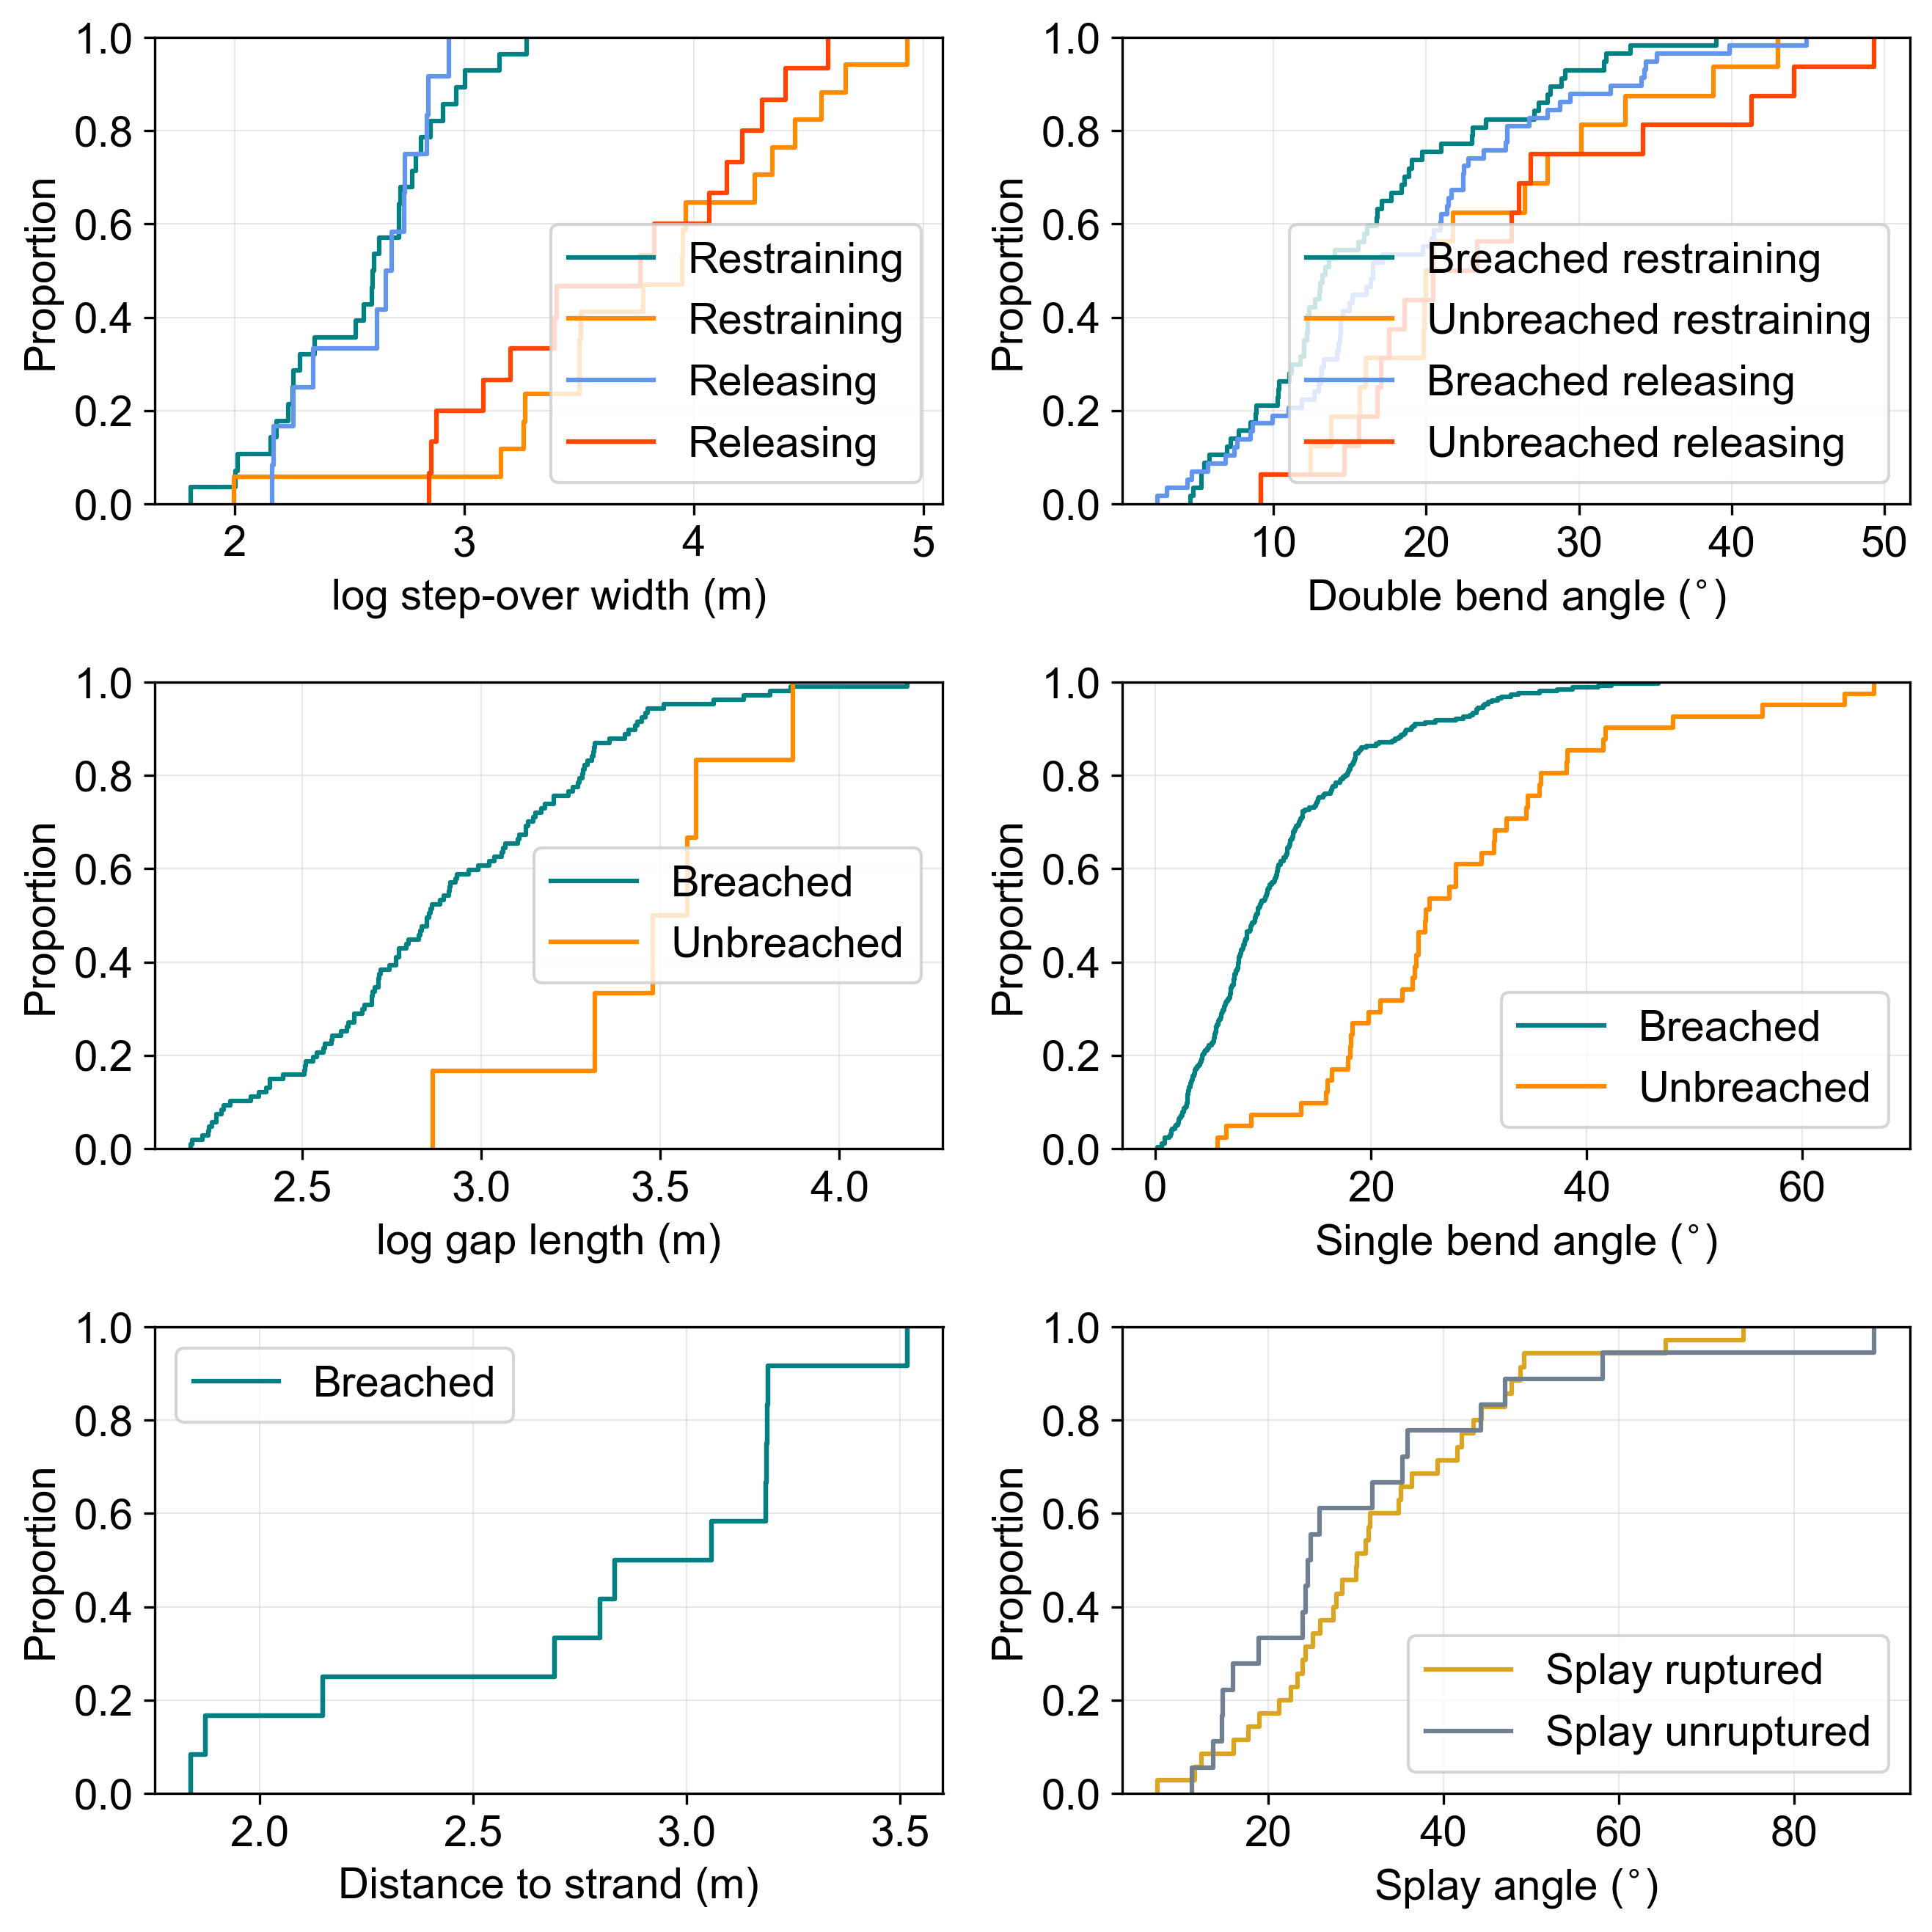

In [485]:
fig, axes = plt.subplots(3,2,figsize=(9,9))

build_cdf(grouped,'stepover', 'restraining', 'length', 'teal','darkorange',axes[0,0] ,'log step-over width (m)','Restraining', 'Restraining')
build_cdf(grouped,'stepover', 'releasing', 'length', 'cornflowerblue','orangered',axes[0,0] , 'log step-over width (m)','Releasing', 'Releasing')
build_cdf(grouped,'bend', 'restraining', 'angle','teal','darkorange',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached restraining', 'Unbreached restraining')
build_cdf(grouped,'bend', 'releasing', 'angle', 'cornflowerblue','orangered',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached releasing', 'Unbreached releasing')
build_cdf(grouped,'gap', 'none', 'length', 'teal','darkorange',axes[1,0] , 'log gap length (m)','Breached', 'Unbreached')
build_cdf(grouped,'bend', 'single', 'angle', 'teal','darkorange',axes[1,1] ,'Single bend angle ($^{\circ}$)','Breached', 'Unbreached')
build_cdf(grouped,'splay', 'none', 'angle', 'goldenrod','slategrey',axes[2,1] ,'Splay angle ($^{\circ}$)','Splay ruptured', 'Splay unruptured')
build_cdf(grouped,'strand', 'none', 'length', 'teal','teal',axes[2,0] ,'Distance to strand (m)','Breached', '')
plt.tight_layout()
plt.savefig('GRL/CDFs.pdf')
plt.show()



log-normal distribution fitting

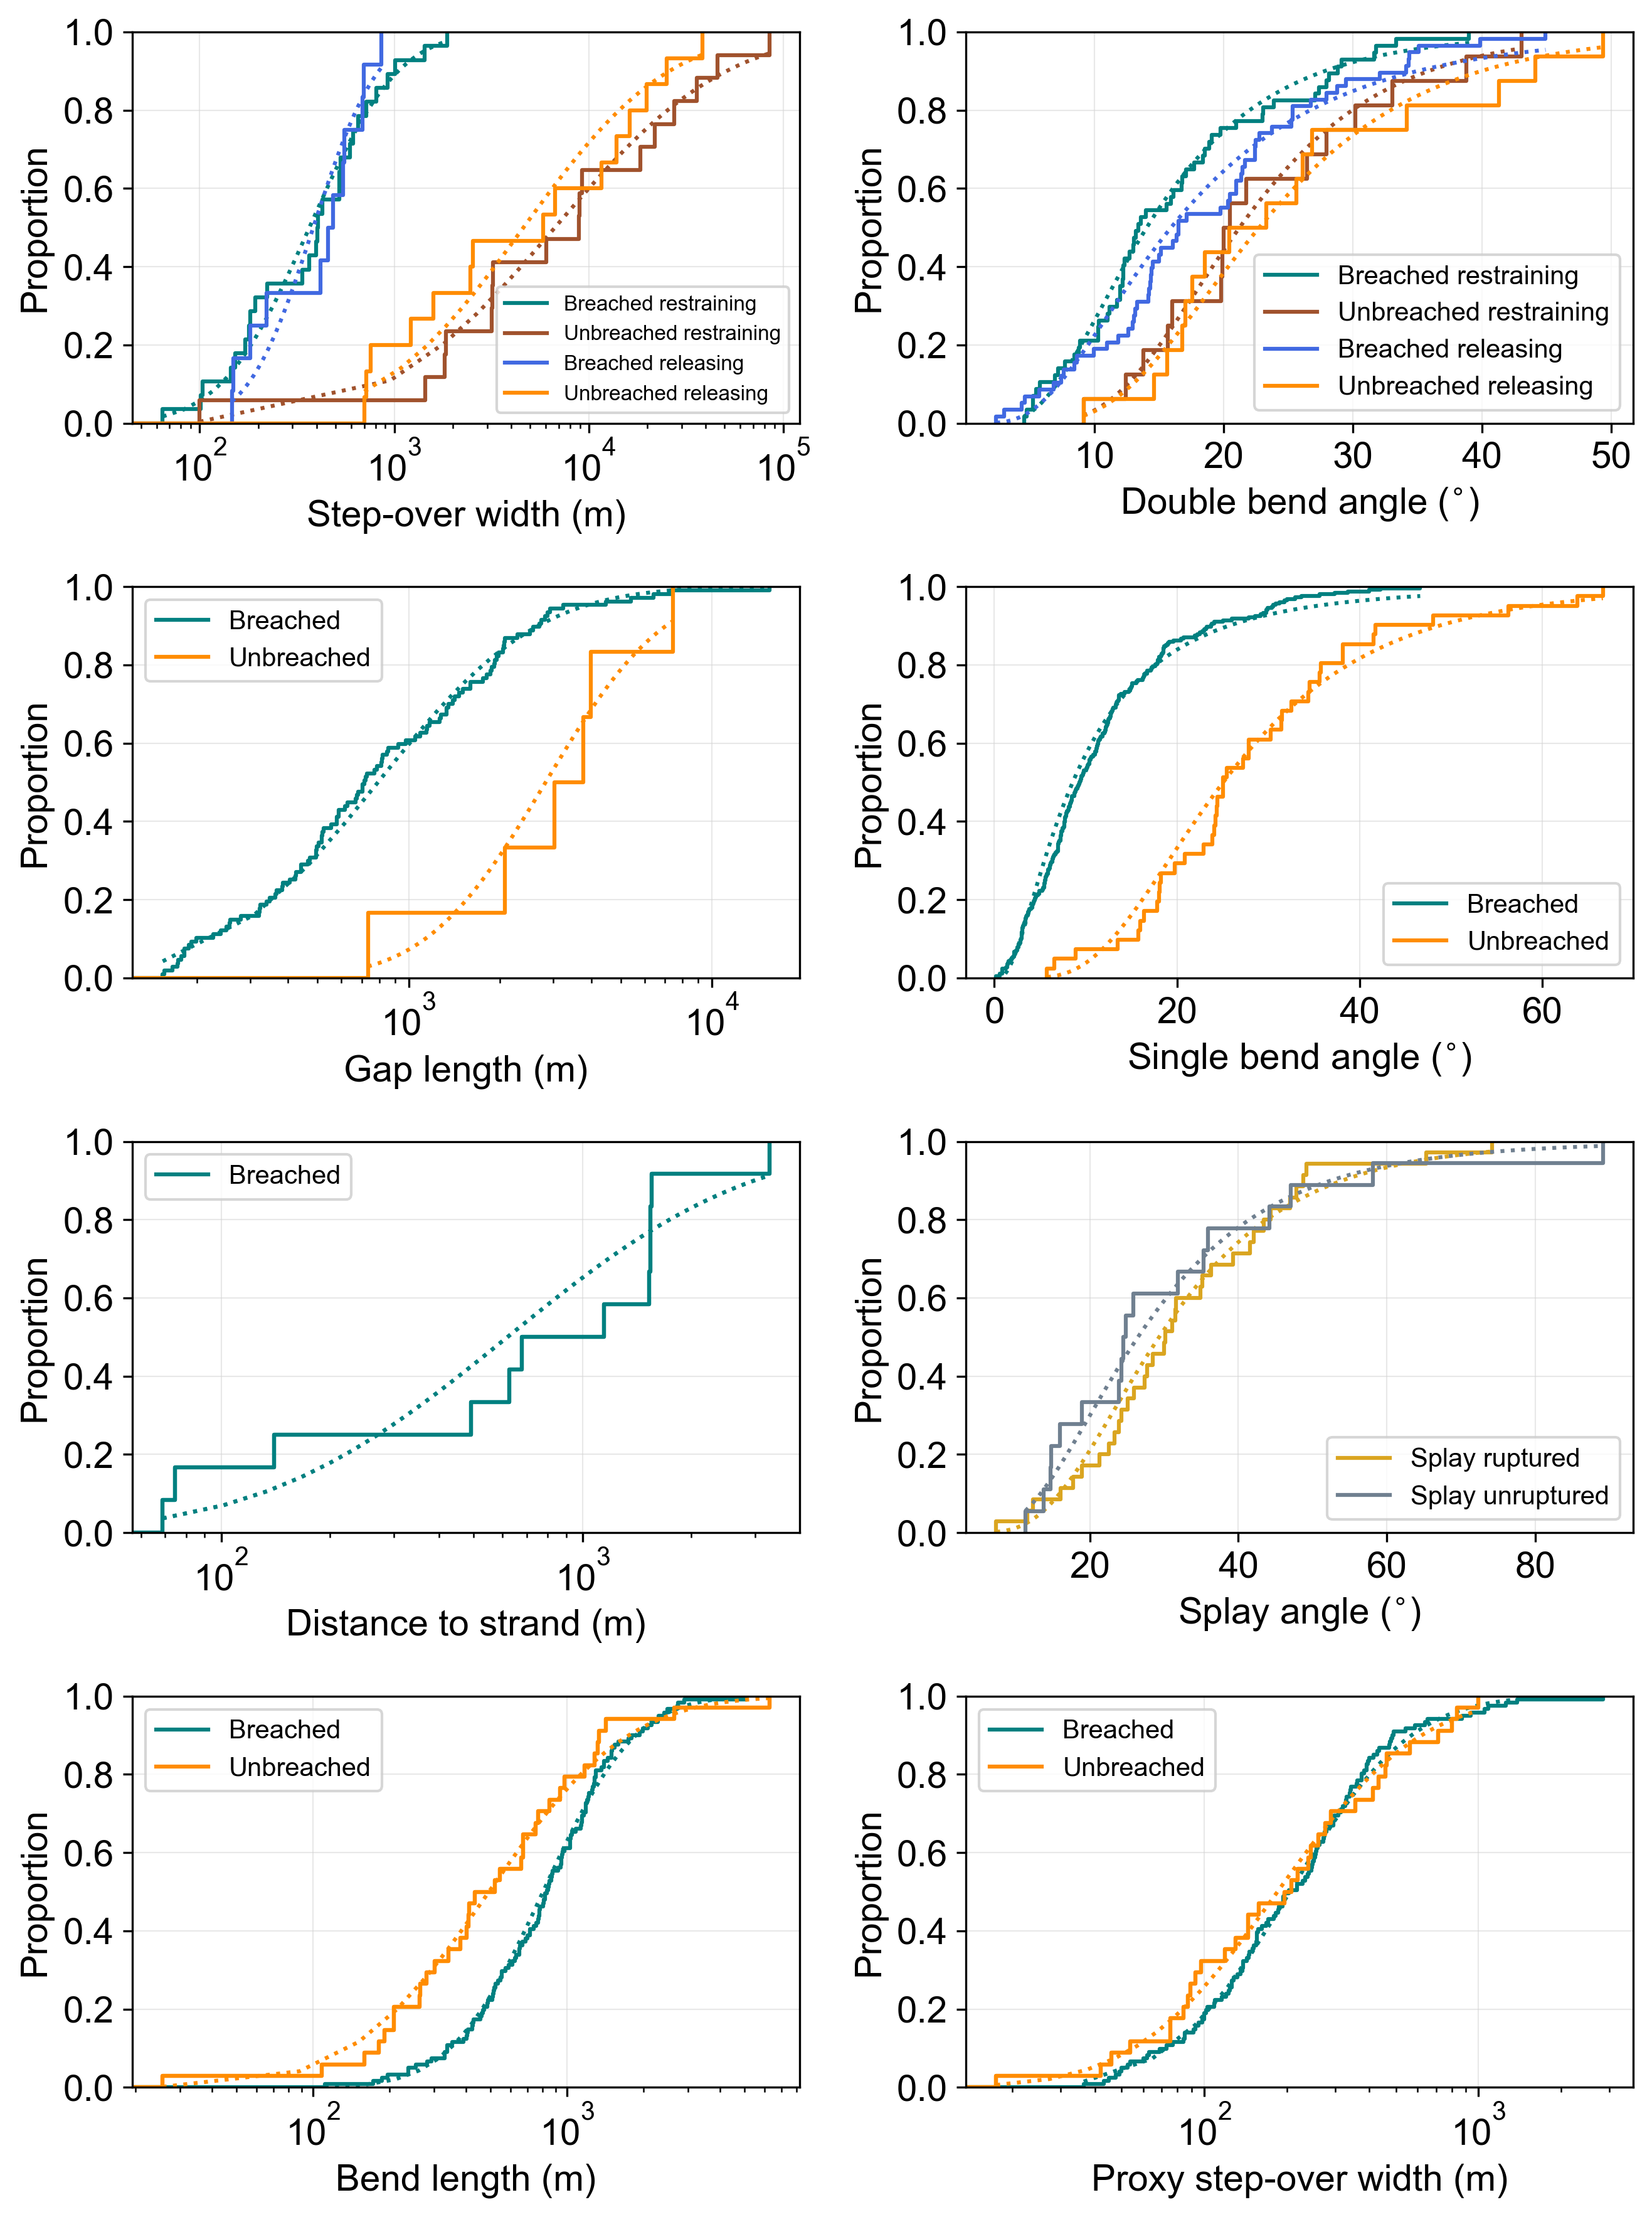

In [486]:
fig, axes = plt.subplots(4,2,figsize=(9,12),dpi=300)

build_cdf_lognorm(grouped,'stepover', 'restraining', 'length', 'teal','sienna',axes[0,0] ,'Step-over width (m)','Breached restraining', 'Unbreached restraining')
build_cdf_lognorm(grouped,'stepover', 'releasing', 'length', 'royalblue','darkorange',axes[0,0] , 'Step-over width (m)','Breached releasing', 'Unbreached releasing')
build_cdf_lognorm(grouped,'bend', 'restraining', 'angle','teal','sienna',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached restraining', 'Unbreached restraining')
build_cdf_lognorm(grouped,'bend', 'releasing', 'angle', 'royalblue','darkorange',axes[0,1] ,'Double bend angle ($^{\circ}$)','Breached releasing', 'Unbreached releasing')
build_cdf_lognorm(grouped,'gap', 'none', 'length', 'teal','darkorange',axes[1,0] , 'Gap length (m)','Breached', 'Unbreached')
build_cdf_lognorm(grouped,'bend', 'single', 'angle', 'teal','darkorange',axes[1,1] ,'Single bend angle ($^{\circ}$)','Breached', 'Unbreached')
build_cdf_lognorm(grouped,'splay', 'none', 'angle', 'goldenrod','slategrey',axes[2,1] ,'Splay angle ($^{\circ}$)','Splay ruptured', 'Splay unruptured')
build_cdf_lognorm(grouped,'strand', 'none', 'length', 'teal','teal',axes[2,0] ,'Distance to strand (m)','Breached', '')
build_cdf_bend_lengths(grouped,'bend', 'double', 'Distance splay or double bend (m)', 'teal','darkorange',axes[3,0],'Bend length (m)','Breached', 'Unbreached')
build_cdf_bend_lengths(grouped,'bend', 'double', 'Spacing double bend (m)', 'teal','darkorange',axes[3,1],'Proxy step-over width (m)','Breached', 'Unbreached')
plt.tight_layout()
plt.savefig('GRL/lognorm_CDFs.pdf')
plt.show()


PDFs

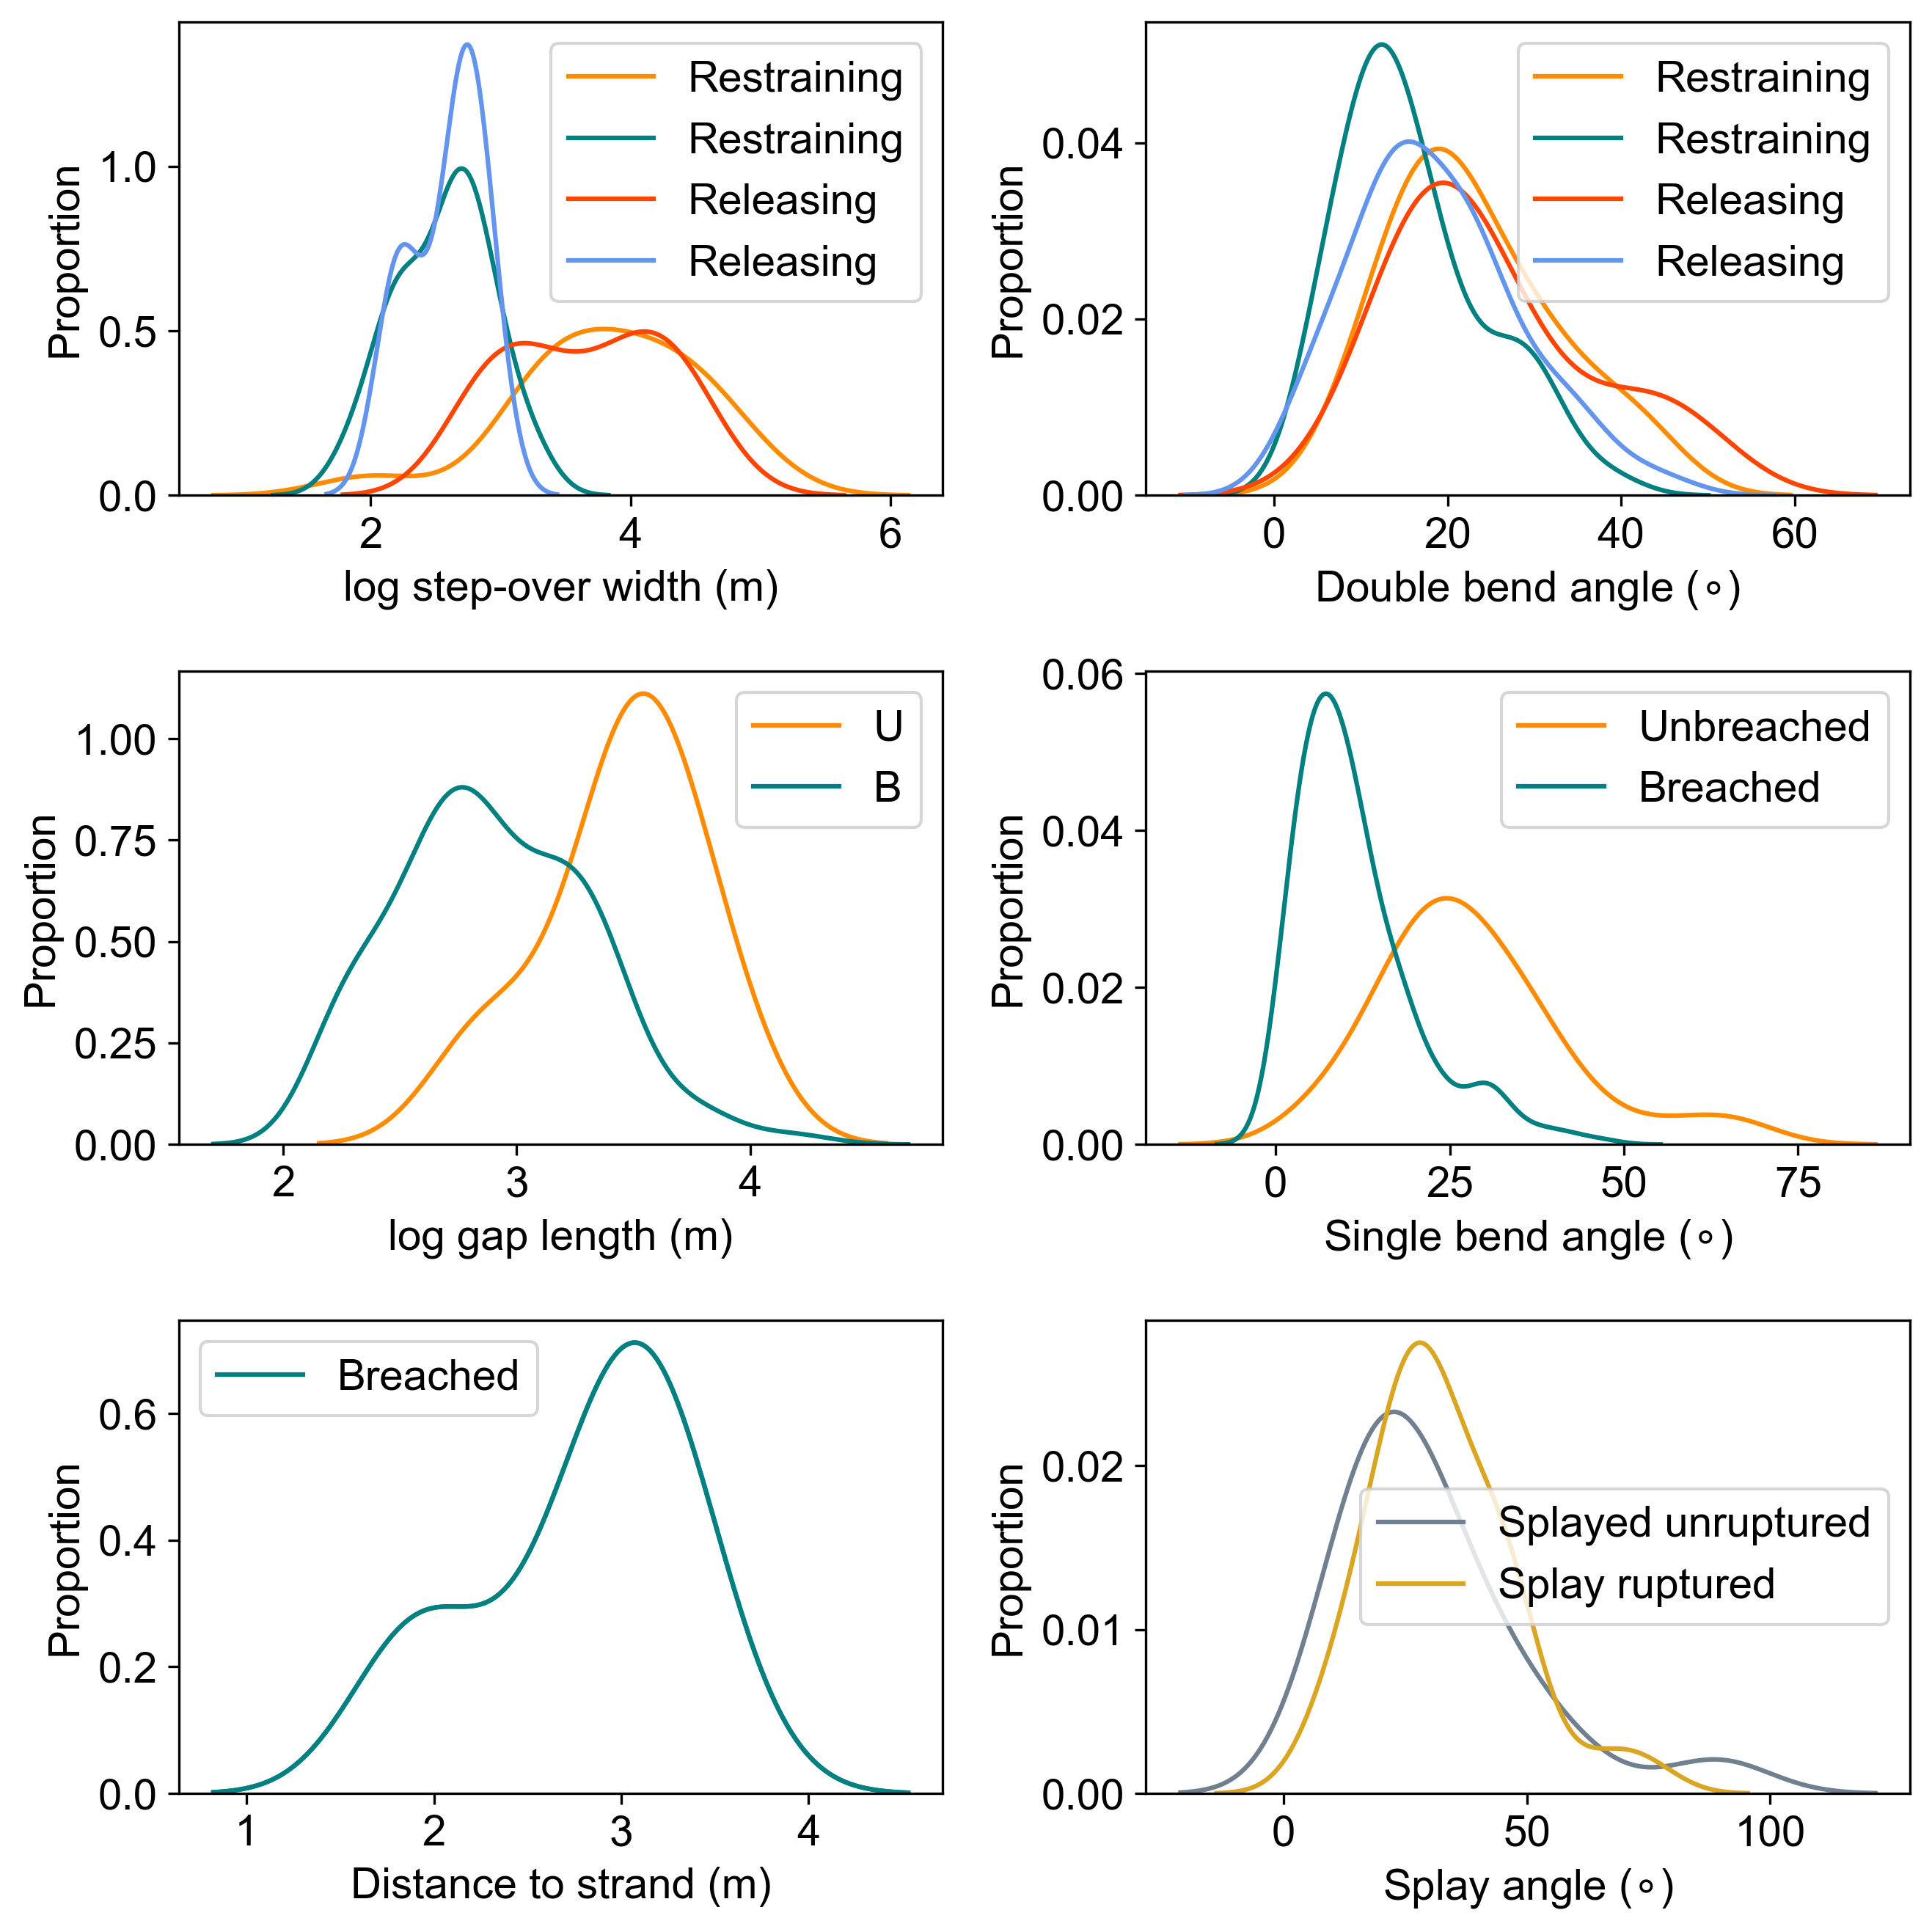

In [487]:
fig, axes = plt.subplots(3,2,figsize=(9,9))

build_pdf(grouped,'stepover', 'restraining', 'length', 'teal','darkorange',axes[0,0] ,'log step-over width (m)','Restraining', 'Restraining')
build_pdf(grouped,'stepover', 'releasing', 'length', 'cornflowerblue','orangered',axes[0,0] , 'log step-over width (m)','Releasing', 'Releasing')
build_pdf(grouped,'bend', 'restraining', 'angle','teal','darkorange',axes[0,1] ,'Double bend angle ($\circ$)','Restraining', 'Restraining')
build_pdf(grouped,'bend', 'releasing', 'angle', 'cornflowerblue','orangered',axes[0,1] ,'Double bend angle ($\circ$)','Releasing', 'Releasing')
build_pdf(grouped,'gap', 'none', 'length', 'teal','darkorange',axes[1,0] , 'log gap length (m)','B', 'U')
build_pdf(grouped,'bend', 'single', 'angle', 'teal','darkorange',axes[1,1] ,'Single bend angle ($\circ$)','Breached', 'Unbreached')
build_pdf(grouped,'splay', 'none', 'angle', 'goldenrod','slategrey',axes[2,1] ,'Splay angle ($\circ$)','Splay ruptured', 'Splayed unruptured')
build_pdf(grouped,'strand', 'none', 'length', 'teal','teal',axes[2,0] ,'Distance to strand (m)','Breached', '')
plt.tight_layout()
plt.savefig('GRL/PDFs.pdf')
plt.show()



ks tests

In [488]:
# ks test for populations of earthquake gates
double_bend_ks = kstest_variables(grouped,'bend', 'double', 'angle')
print('double_bend_ks')
print(double_bend_ks)

single_bend_ks = kstest_variables(grouped,'bend', 'single', 'angle')
print('single_bend_ks')
print(single_bend_ks)

stepover_ks= kstest_variables(grouped,'stepover', 'none', 'length')
print('stepover_ks')
print(stepover_ks)


gap_ks = kstest_variables(grouped,'gap', '', 'length')
print('gap_ks')
print(gap_ks)

splay_ks = kstest_variables(grouped,'splay', 'none', 'angle')
print('splay_ks')
print(splay_ks)

releasing_restraining_unbreached_bend_ks = kstest_variables(grouped,'bend', 'releasing_restraining_unbreached', 'angle')
print('releasing_restraining_unbreached_bend_ks')
print(releasing_restraining_unbreached_bend_ks)

releasing_restraining_breached_bend_ks = kstest_variables(grouped,'bend', 'releasing_restraining_breached', 'angle')
print('releasing_restraining_breached_bend_ks')
print(releasing_restraining_breached_bend_ks)

releasing_restraining_breached_stepover_ks = kstest_variables(grouped,'stepover', 'releasing_restraining_breached', 'length')
print('releasing_restraining_breached_stepover_ks')
print(releasing_restraining_breached_stepover_ks)

releasing_restraining_unbreached_stepover_ks = kstest_variables(grouped,'stepover', 'releasing_restraining_unbreached', 'length')
print('releasing_restraining_unbreached_stepover_ks')
print(releasing_restraining_unbreached_stepover_ks)

double_bend_ks
KstestResult(statistic=0.35342732134175986, pvalue=0.0017895704567134141, statistic_location=14.5462313088188, statistic_sign=1)
single_bend_ks
KstestResult(statistic=0.6641577743902439, pvalue=1.395435322019416e-15, statistic_location=15.6935103227513, statistic_sign=1)
stepover_ks
KstestResult(statistic=0.825, pvalue=9.731253192033982e-13, statistic_location=3.0036662138676324, statistic_sign=1)
gap_ks
KstestResult(statistic=0.6931464174454829, pvalue=0.003105786961433629, statistic_location=3.3156138688628625, statistic_sign=1)
splay_ks
KstestResult(statistic=0.26825396825396824, pvalue=0.2913436152990529, statistic_location=25.8837228358785, statistic_sign=-1)
releasing_restraining_unbreached_bend_ks
KstestResult(statistic=0.125, pvalue=0.9998909696588173, statistic_location=18.5685515277188, statistic_sign=1)
releasing_restraining_breached_bend_ks
KstestResult(statistic=0.2335148215366001, pvalue=0.07319871254951311, statistic_location=14.0183033402183, statistic_si

# Plot passing probabilities and earthquake gate analysis

Logistic models

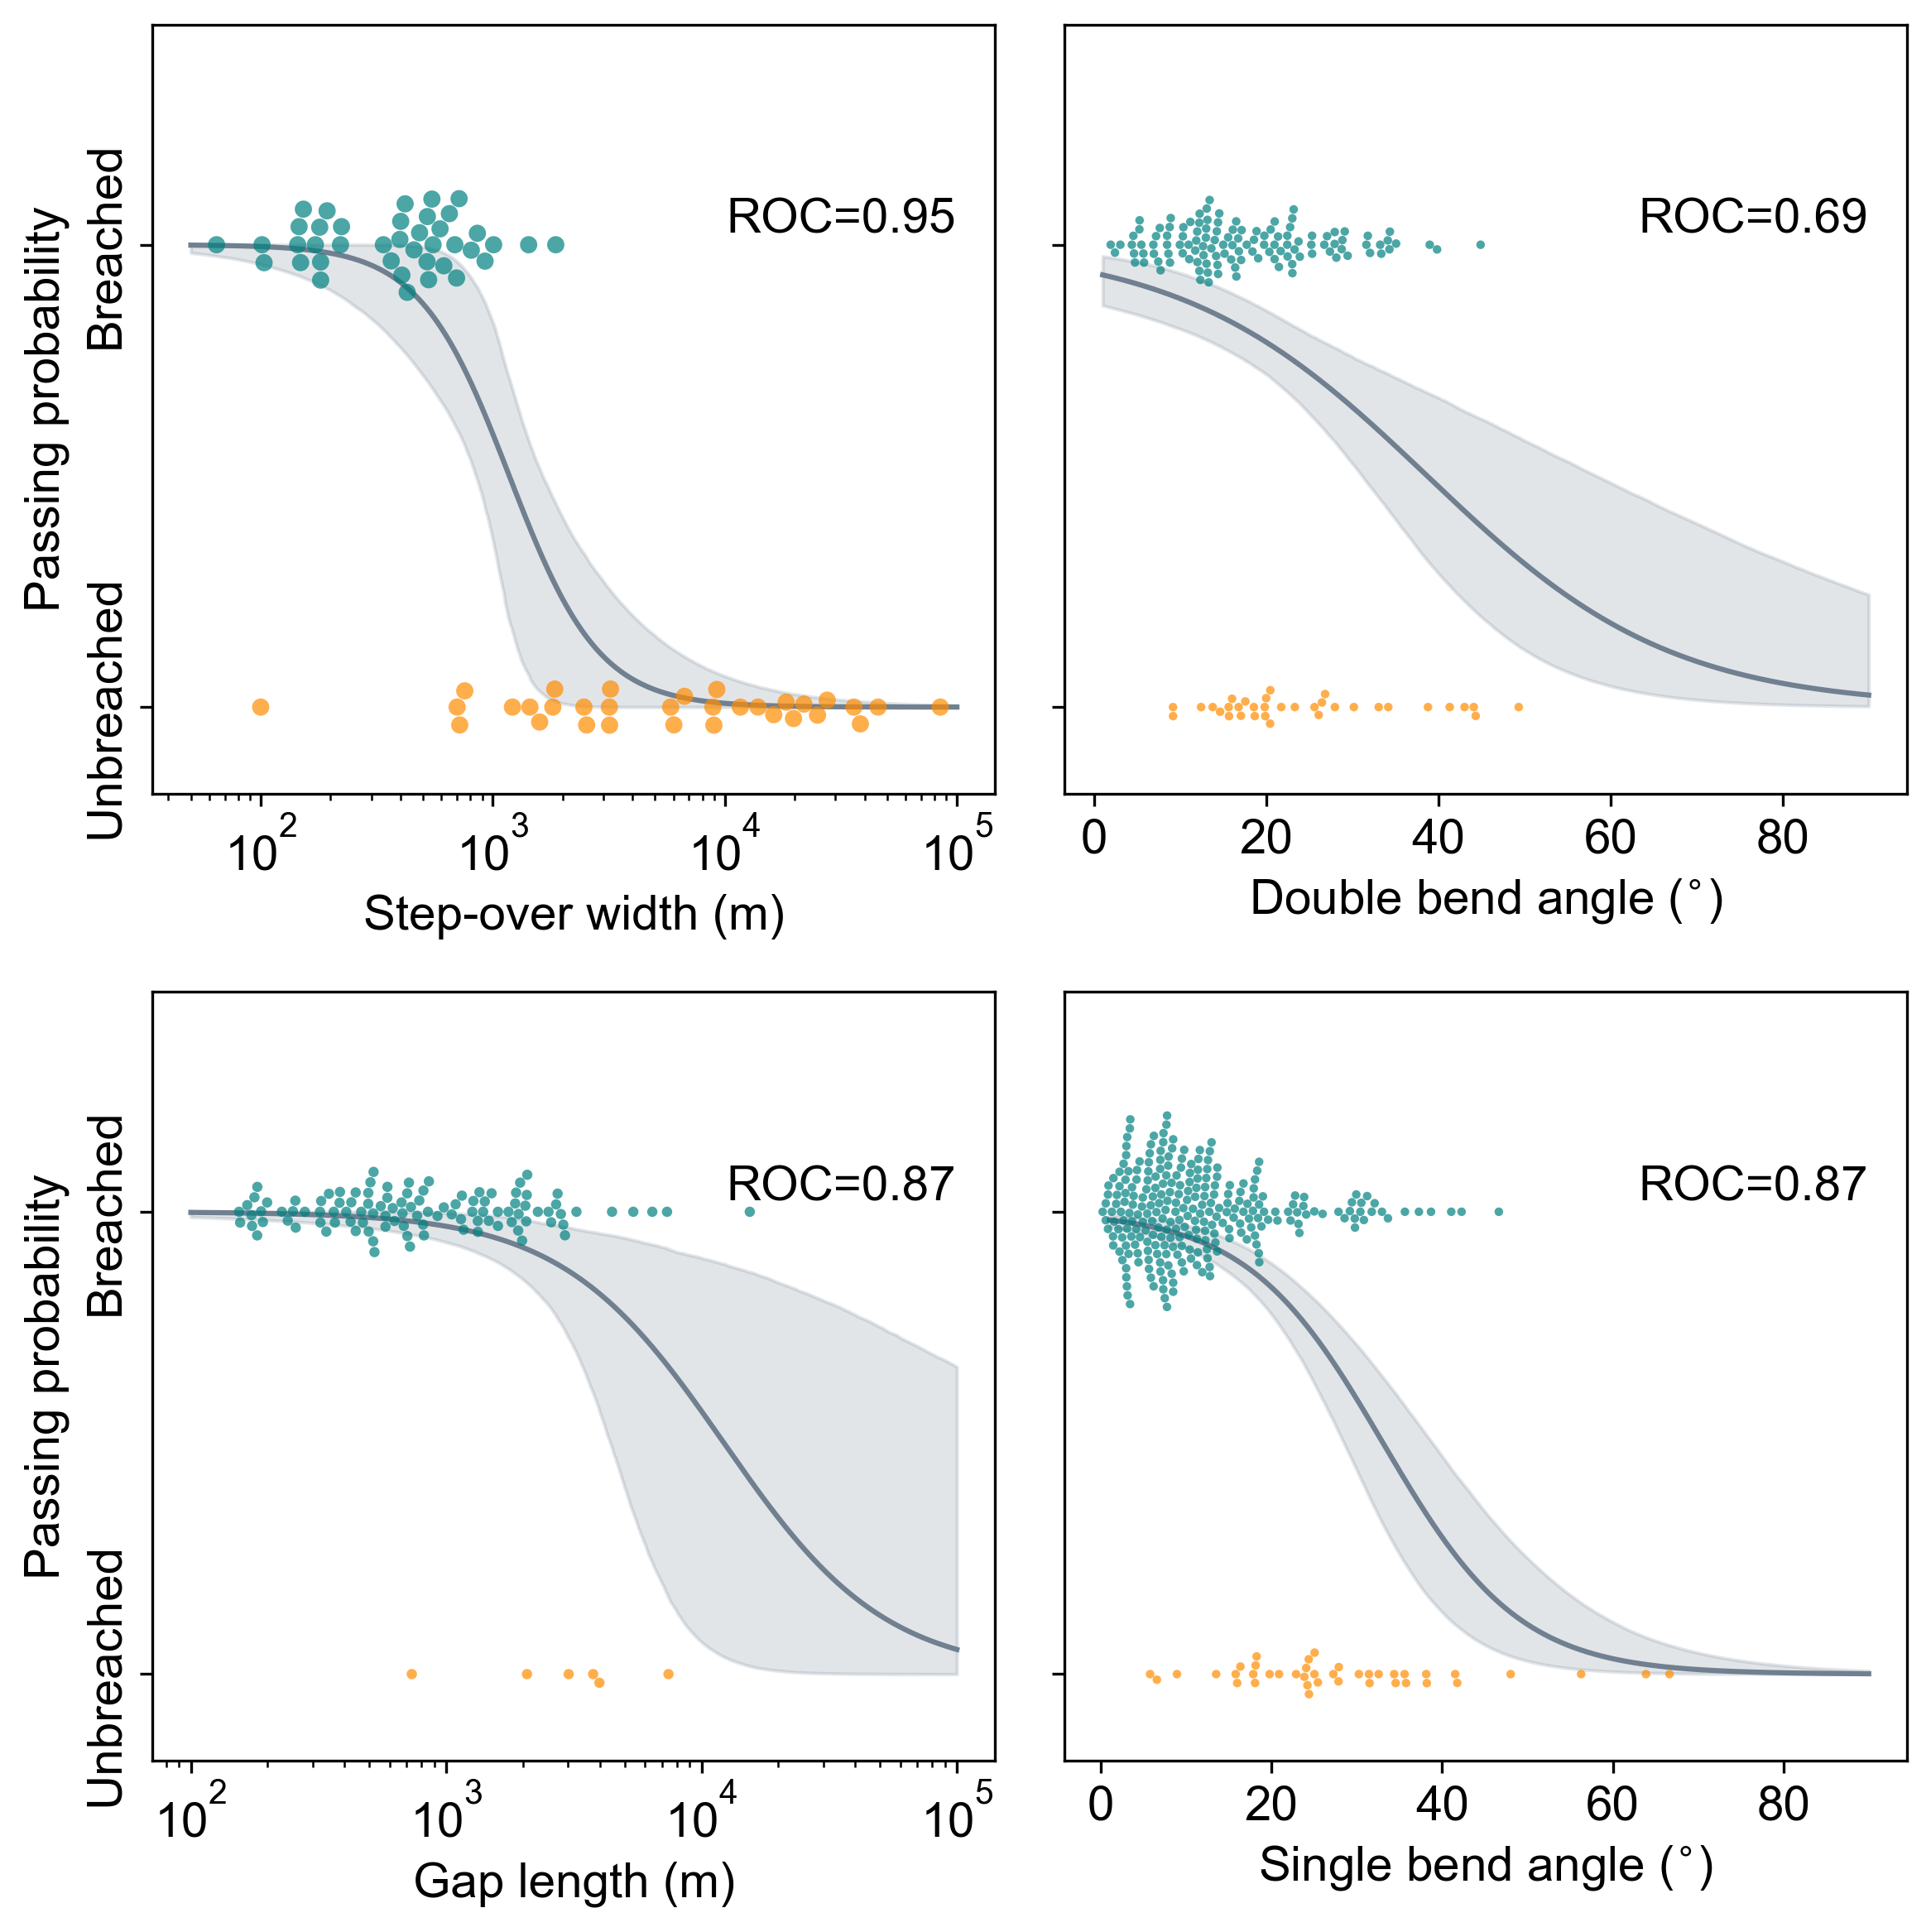

In [489]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharey=True, dpi=300)
 
log_stepover, acc_stepover, pre_stepover, f1_stepover, roc_stepover, confusion_matrix_stepover, BUbin_stepover,xstepover = build_logistic_regression(
    grouped,
    'stepover', 
    'none', 
    'length', 
    None, 
    axes[0,0],
    50,
    100000,
    'slategrey',
    'Step-over width (m)',
    5
)

log_bend_double, acc_bend_double, pre_bend_double, f1_bend_double, roc_bend_double, confusion_matrix_bend_double,BUbin_bend_double,xbenddouble= build_logistic_regression(grouped,'bend', 'double', 'angle',None,axes[0,1],1,90,'slategrey','Double bend angle ($^{\circ}$)',2.5)
log_bend_single, acc_bend_single, pre_bend_single, f1_bend_single, roc_bend_single, confusion_matrix_bend_single,BUbin_bend_single,xbendsingle = build_logistic_regression(grouped,'bend', 'single', 'angle', None,
                                                                                                                                                                           axes[1,1],1,90,'slategrey','Single bend angle ($^{\circ}$)',2.5)

log_gap, acc_gap, pre_gap, f1_gap, roc_gap, confusion_matrix_gap, BUbin_gap,xgap = build_logistic_regression(grouped,'gap', 'none', 'length', None, axes[1,0],100,100000,'slategrey','Gap length (m)',3)


plt.tight_layout()
plt.savefig('GRL/PP_EQgates.pdf')
plt.show()

logistic regression for releasing and restraining subgroups

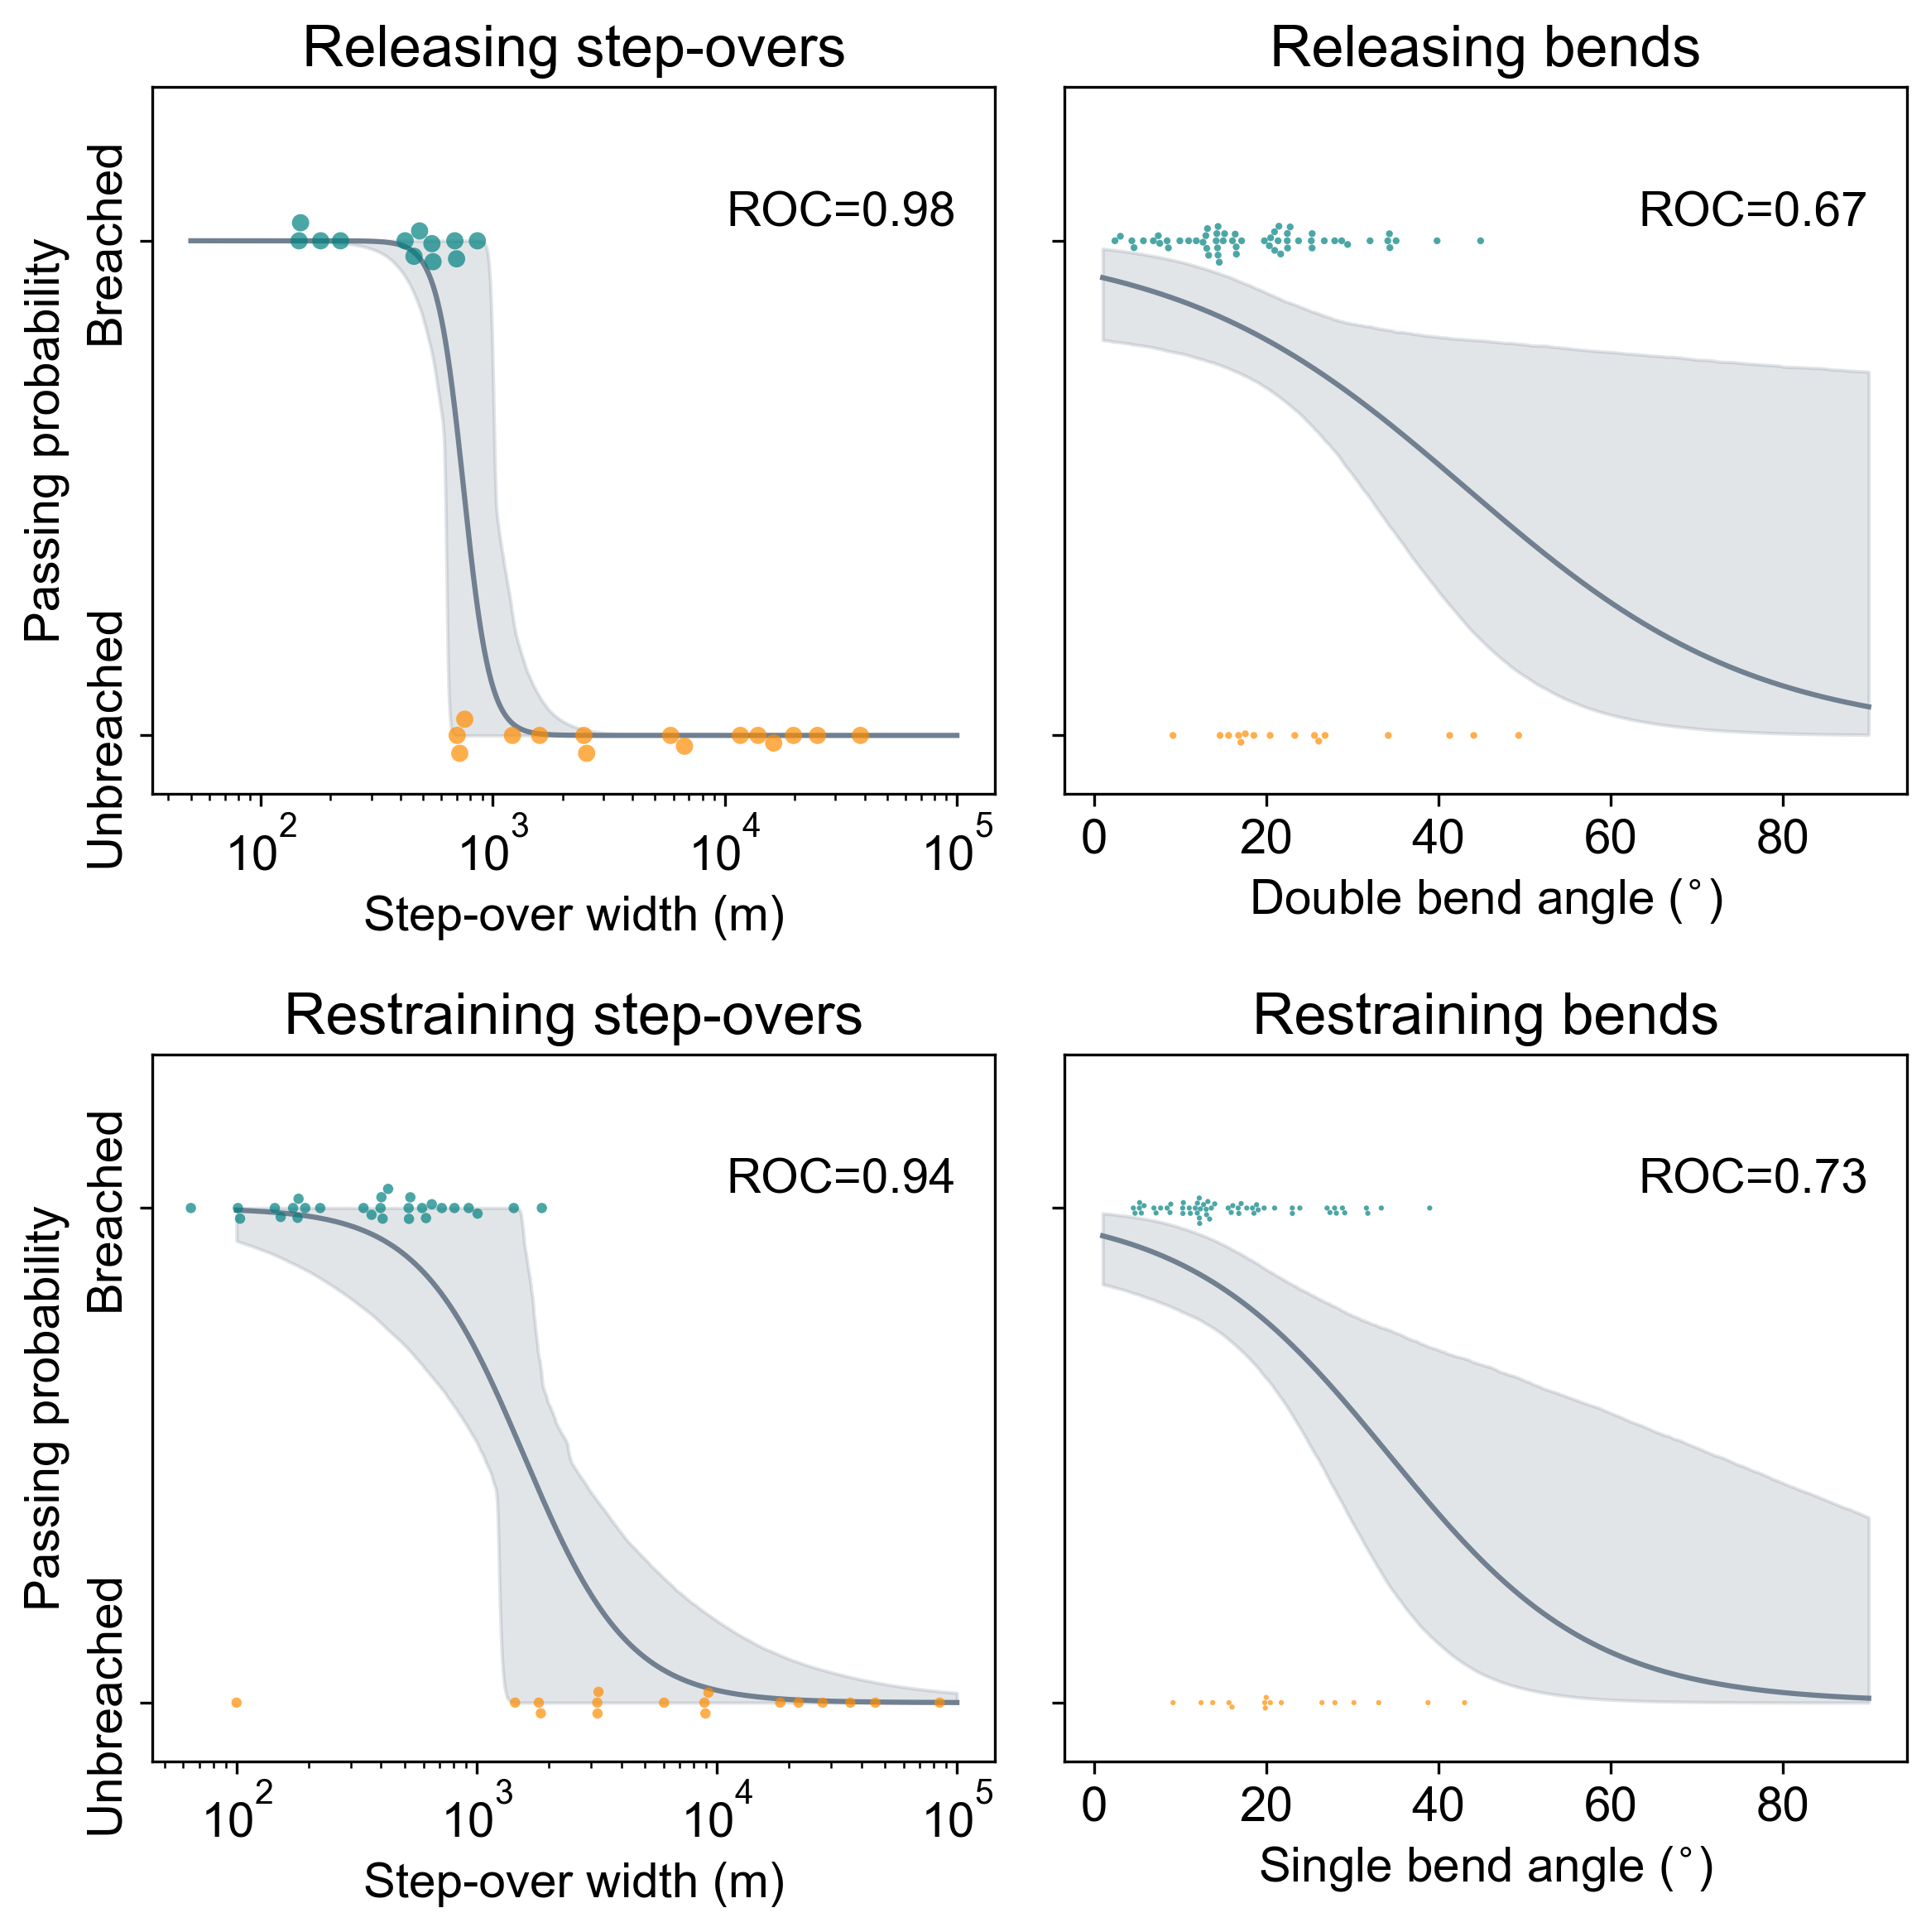

In [490]:
fig, axes = plt.subplots(2,2,figsize=(8,8), sharey=True, dpi=300)
 
build_logistic_regression(
    grouped,
    'stepover', 
    'releasing', 
    'length', 
    None, 
    axes[0,0],
    50,
    100000,
    'slategrey',
    'Step-over width (m)',
    5
)

build_logistic_regression(grouped,'bend', 'releasing', 'angle', None,
                         axes[0,1],1,90,'slategrey','Double bend angle ($^{\circ}$)',2)
build_logistic_regression(grouped,'bend', 'restraining', 'angle', None, 
                         axes[1,1],1,90,'slategrey','Single bend angle ($^{\circ}$)',1.5)
build_logistic_regression(grouped,'stepover', 'restraining', 'length', None, 
                          axes[1,0],100,100000,'slategrey','Step-over width (m)',3)

axes[0,0].set_title('Releasing step-overs')
axes[0,1].set_title('Releasing bends')
axes[1,1].set_title('Restraining bends')
axes[1,0].set_title('Restraining step-overs')

plt.tight_layout()
plt.savefig('GRL/PP_EQgates_RR_categories.pdf')
plt.show()

Predict probability for earthquake gate of given geometry based on logistic model for that type of earthquake gate

In [491]:
x = np.atleast_2d(34).T
# x = np.atleast_2d(np.log10(19000)).T
proba = log_bend_single.predict_proba(x)[:,0]
proba

array([0.47083413])

Let's assess the quality of the logistic regressions. 

In [492]:
print("ROC step-over",roc_stepover)
print("ROC single bend",roc_bend_single)
print("ROC double bend",roc_bend_double)
print("ROC gap",roc_gap)

ROC step-over 0.9500000000000001
ROC single bend 0.8707126524390244
ROC double bend 0.6920272241127856
ROC gap 0.8707165109034268


### double bend/step-over proxy analysis

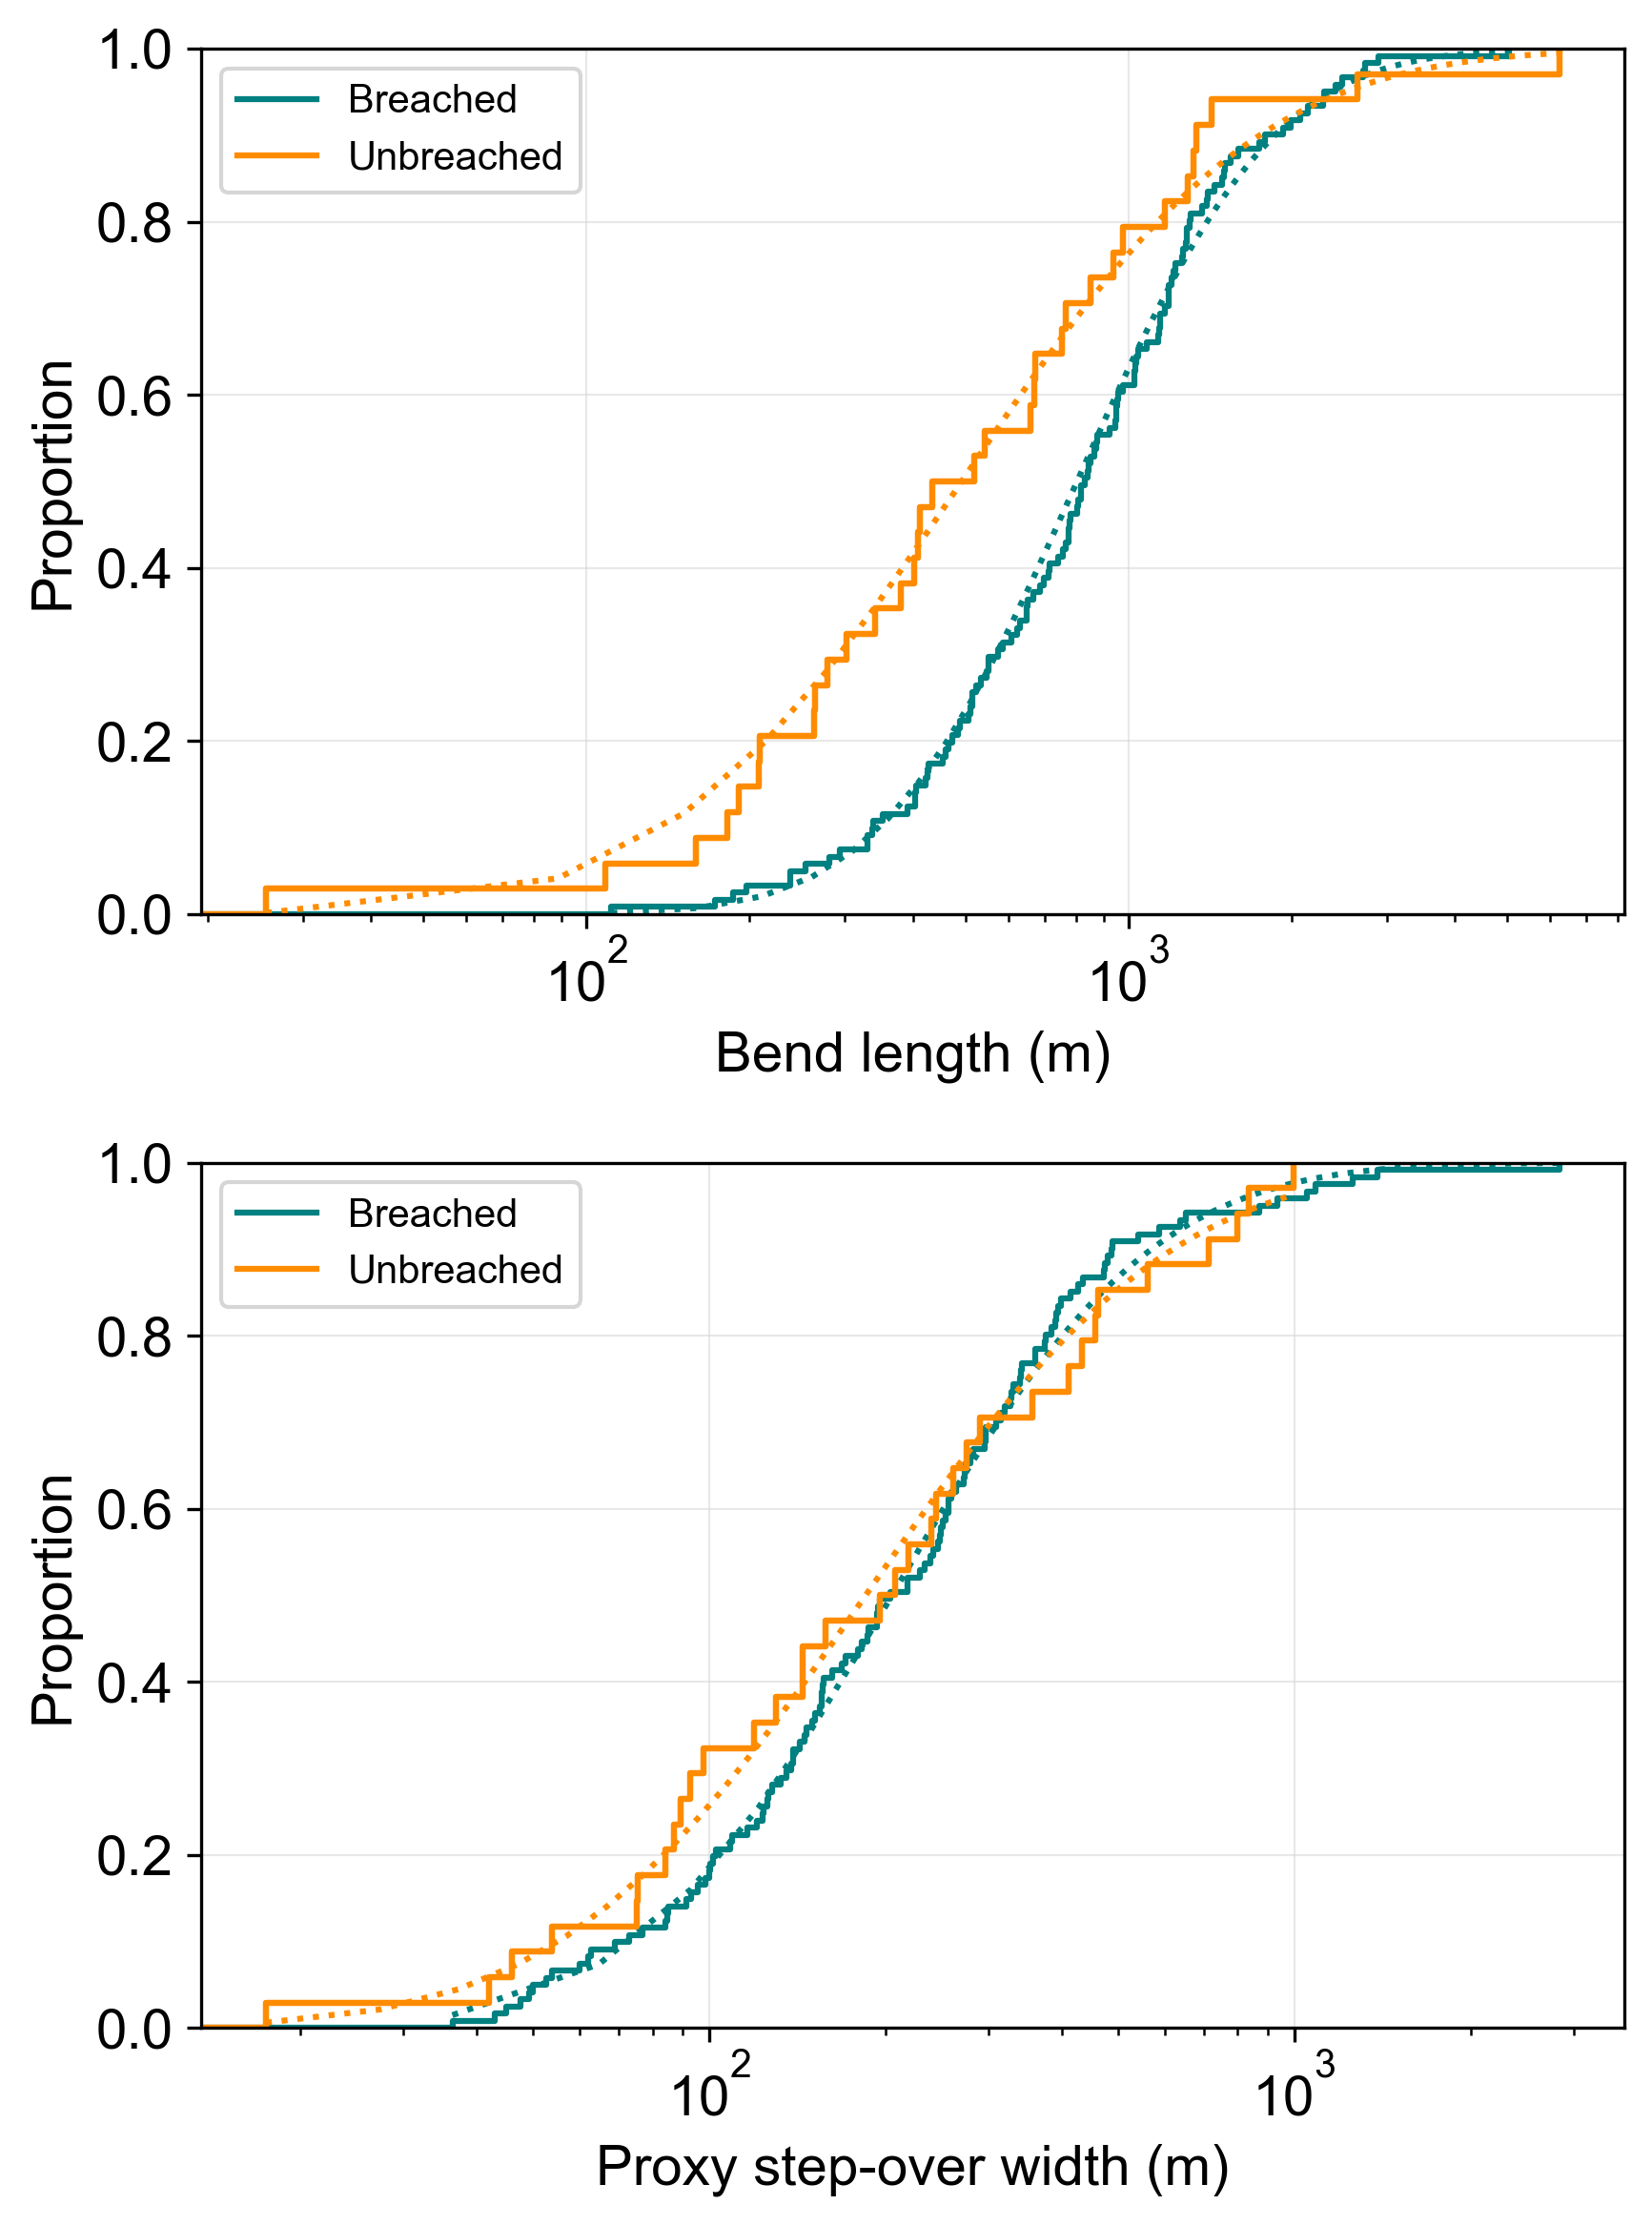

In [493]:
fig, ax = plt.subplots(2,1,figsize=(6,8), dpi=300)
build_cdf_bend_lengths(grouped,'bend', 'double', 'Distance splay or double bend (m)', 'teal','darkorange',ax[0],'Bend length (m)','Breached', 'Unbreached')
build_cdf_bend_lengths(grouped,'bend', 'double', 'Spacing double bend (m)', 'teal','darkorange',ax[1],'Proxy step-over width (m)','Breached', 'Unbreached')
plt.tight_layout()
plt.savefig('GRL/bend_length_CDFs.pdf')

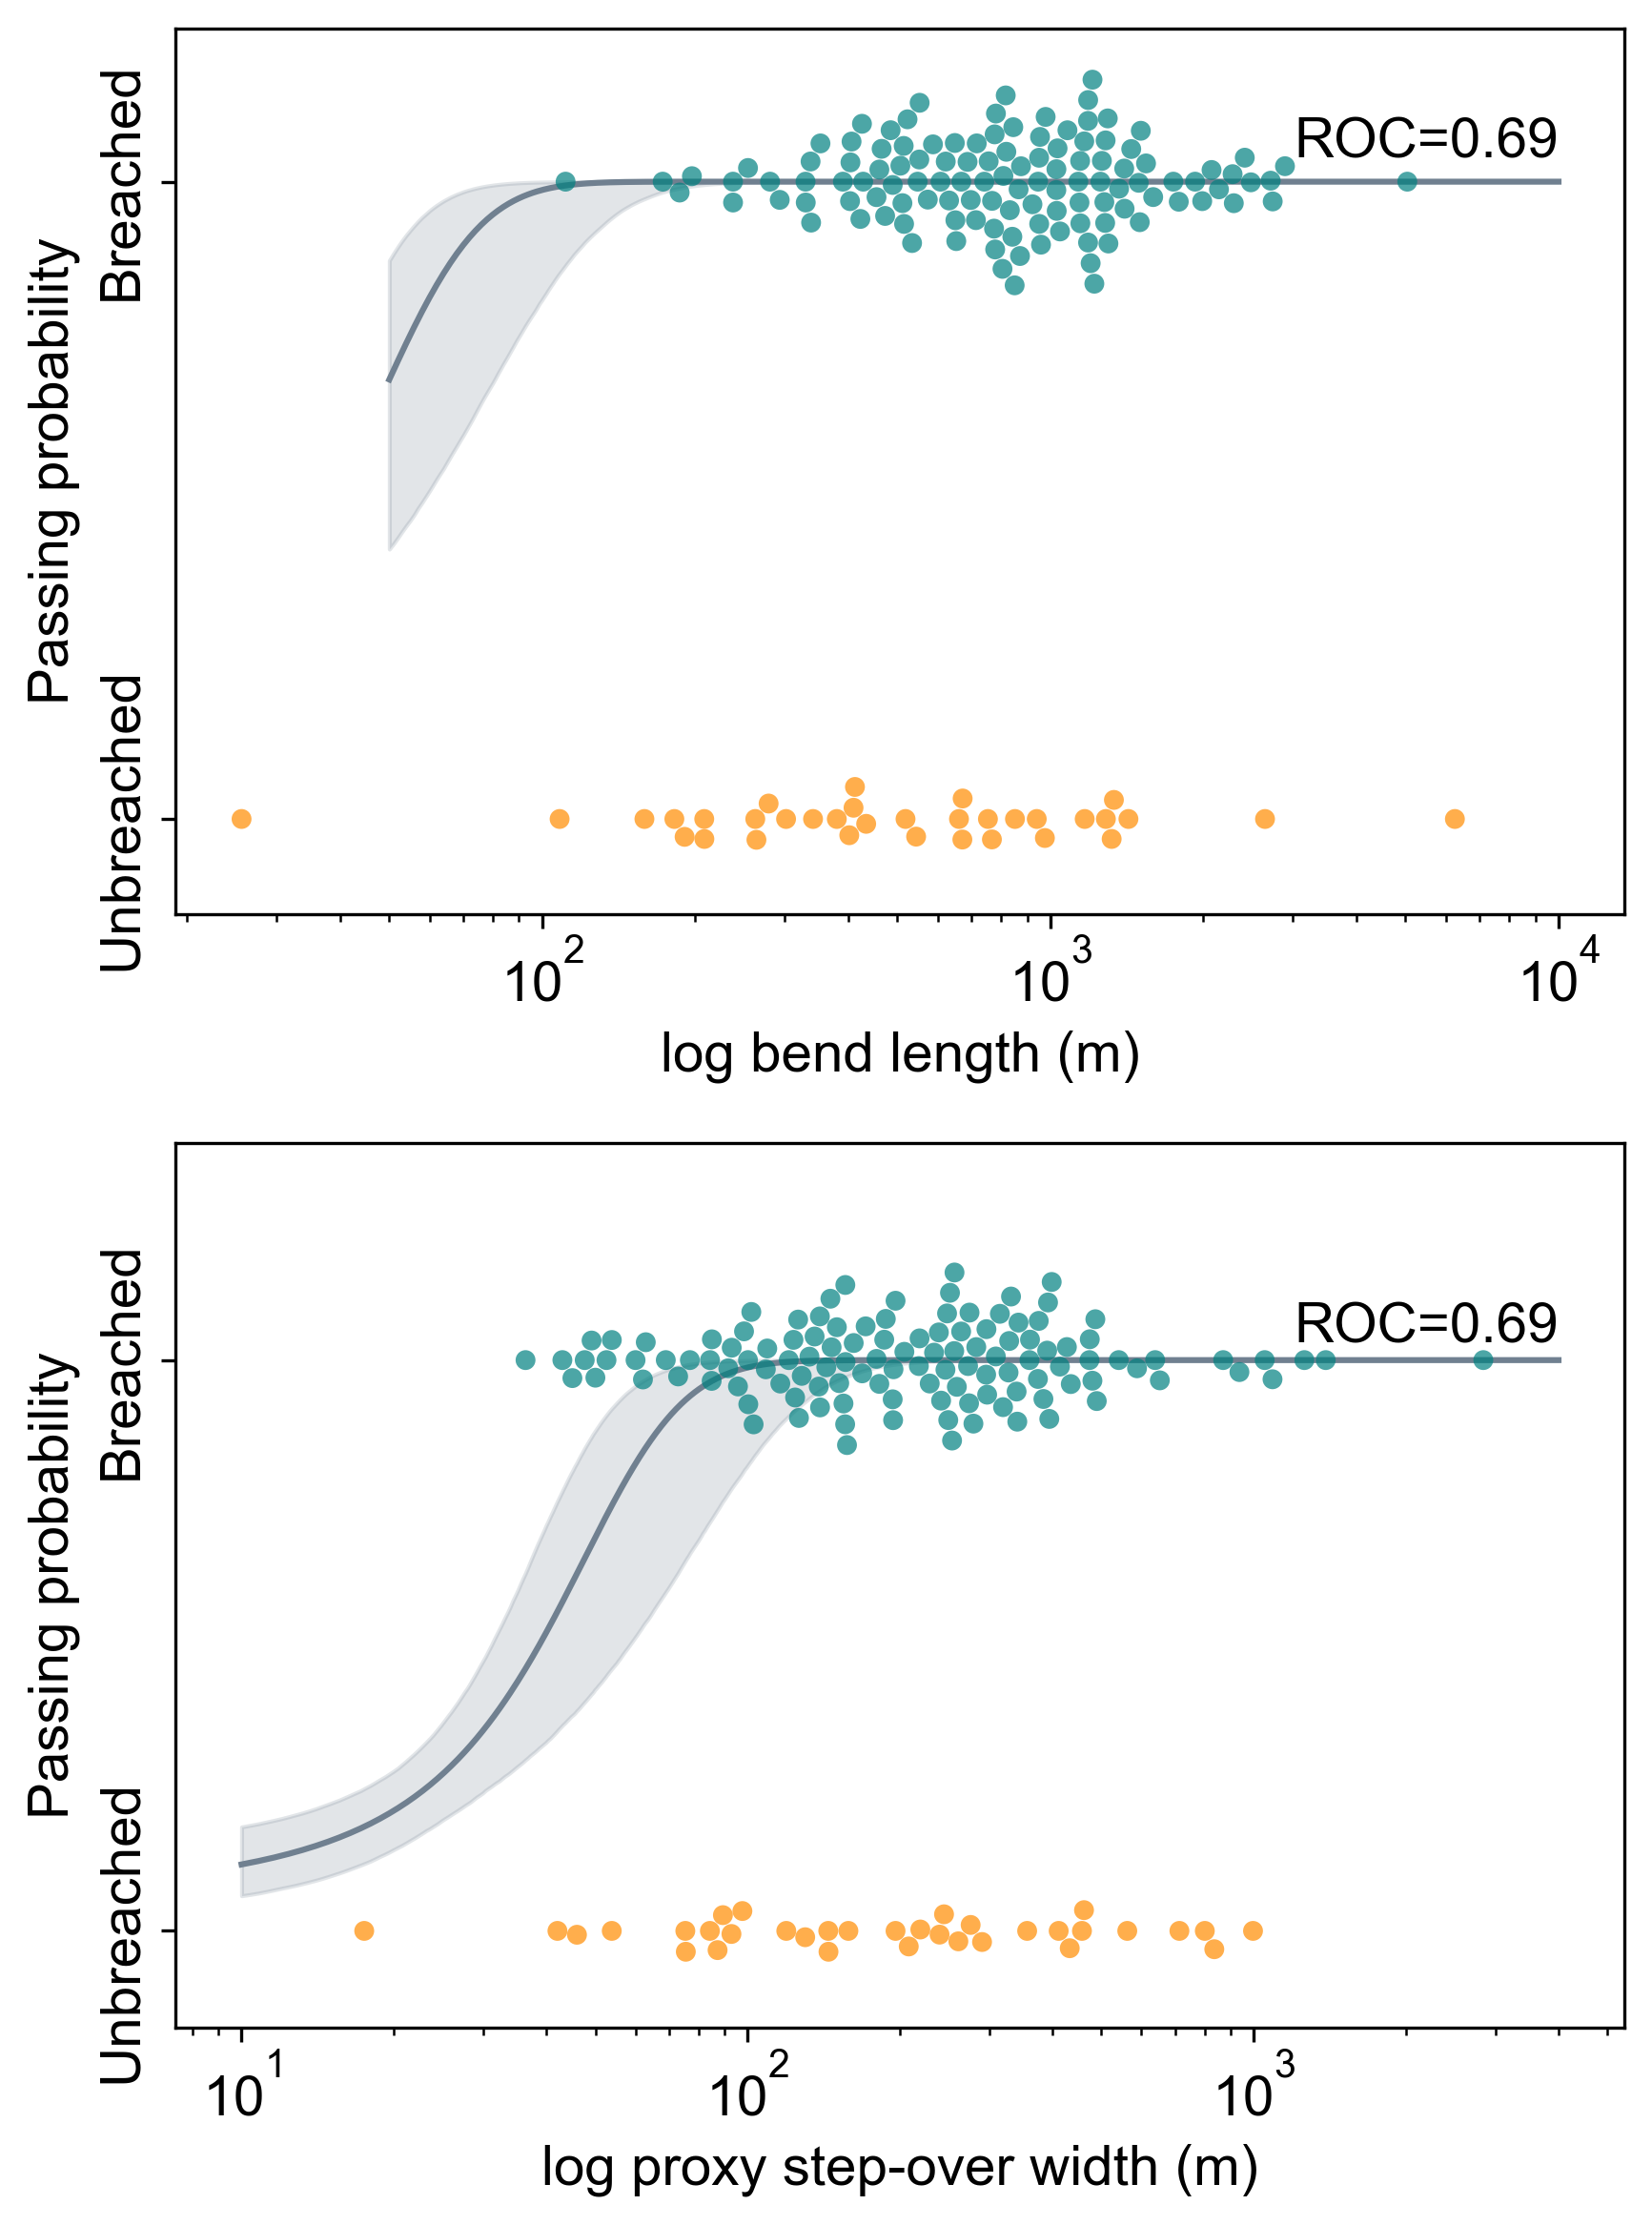

In [494]:
fig, ax = plt.subplots(2,1,figsize=(6,8), dpi=300)
build_regression_double_bend_length(grouped,'bend', 'double', 'Distance splay or double bend (m)',ax[0],50,10000,'log bend length (m)',5)
build_regression_double_bend_length(grouped,'bend', 'double', 'Spacing double bend (m)',ax[1],10,4000,'log proxy step-over width (m)',5)
plt.tight_layout()
plt.savefig('GRL/bend_lengths.pdf.pdf')

Confusion matrices to evaluate logistic model fit

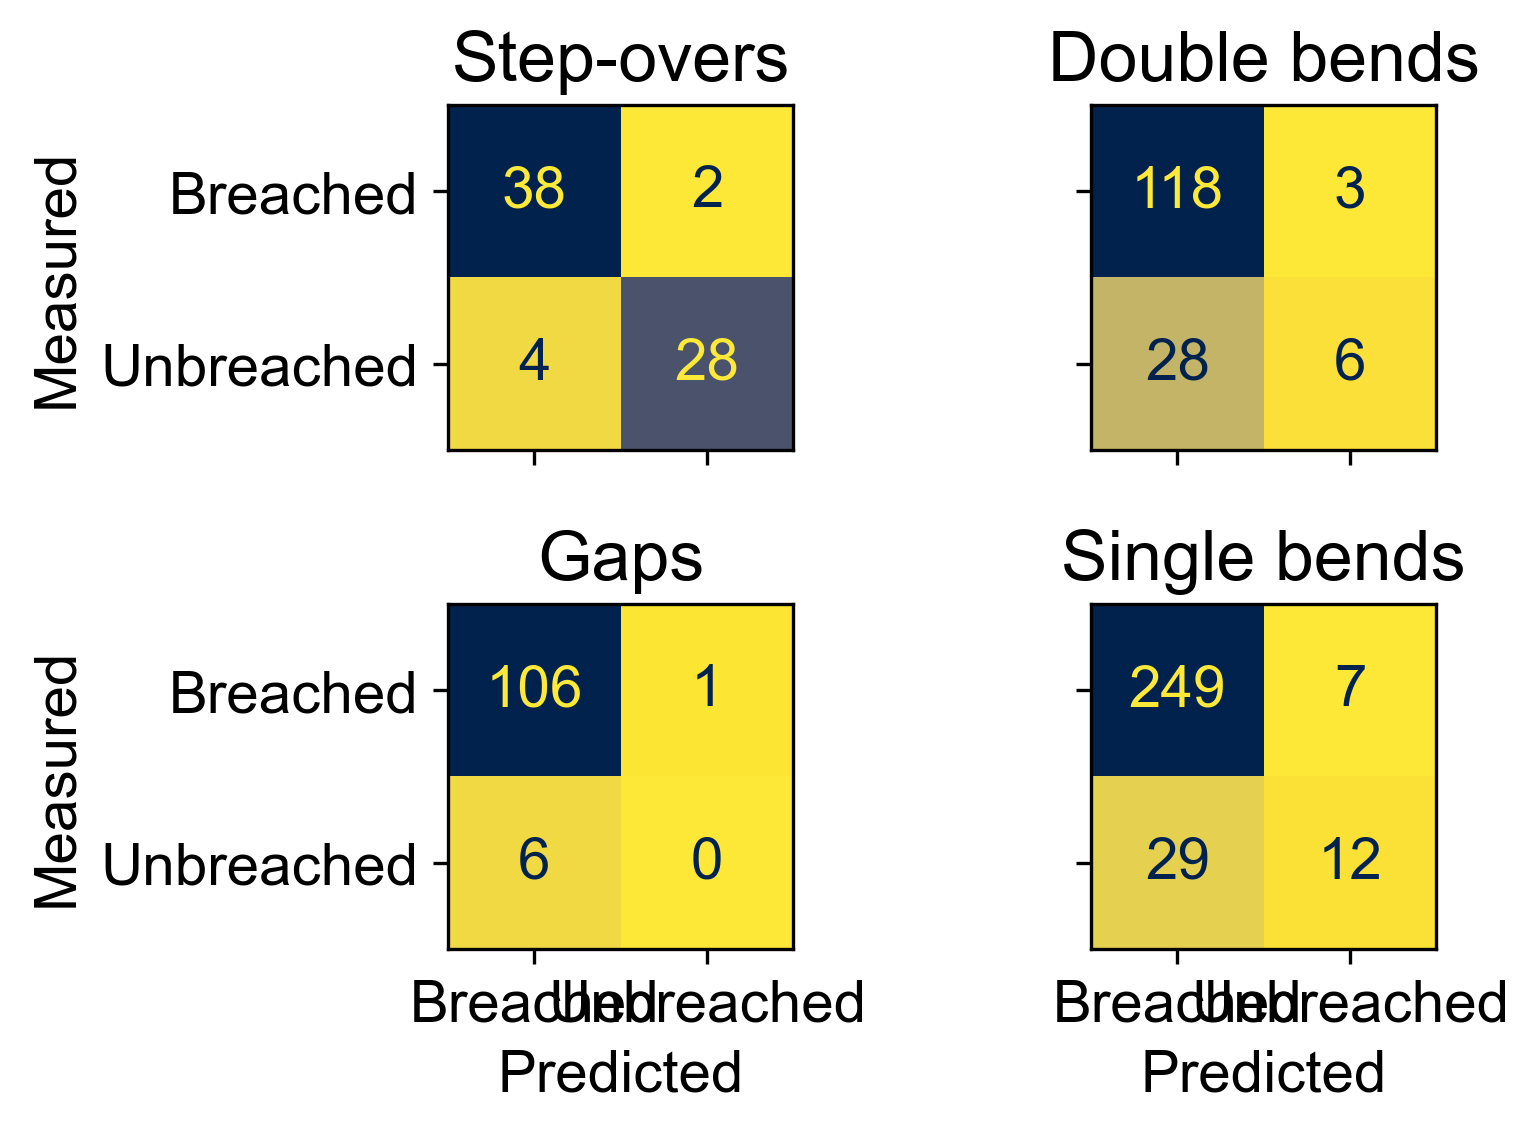

In [495]:
fig, axes = plt.subplots(2,2,figsize=(6,4), dpi=300,sharex=True,sharey=True)

# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('cividis')
labels = ['Breached', 'Unbreached']
  
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

disp_stepover = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_stepover,display_labels=labels)
disp_stepover.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[0,0])
axes[0,0].set_title('Step-overs')
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Measured')

disp_double_bend = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bend_double,display_labels=labels)
disp_double_bend.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[0,1])
axes[0,1].set_title('Double bends')
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')

disp_double_single = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_bend_single,display_labels=labels)
disp_double_single.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[1,1])
axes[1,1].set_title('Single bends')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('')

disp_gap = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_gap,display_labels=labels)
disp_gap.plot(cmap=reversed_map, include_values=True,colorbar=False,ax = axes[1,0])
axes[1,0].set_title('Gaps')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Measured')

plt.tight_layout()
plt.savefig('GRL/confusion_matrices.pdf')
plt.show()


ks tests:

In [496]:
# ks test for determining whether populations are different (statistically)
mpl.rcParams['font.size'] = 14
double_bend_ks = kstest_variables(grouped,'bend', 'single', 'angle')
print(double_bend_ks)
splay_ks = kstest_variables(grouped,'splay', 'none', 'angle')
print(splay_ks)

KstestResult(statistic=0.6641577743902439, pvalue=1.395435322019416e-15, statistic_location=15.6935103227513, statistic_sign=1)
KstestResult(statistic=0.26825396825396824, pvalue=0.2913436152990529, statistic_location=25.8837228358785, statistic_sign=-1)


Nearest distance between strand and step-over:

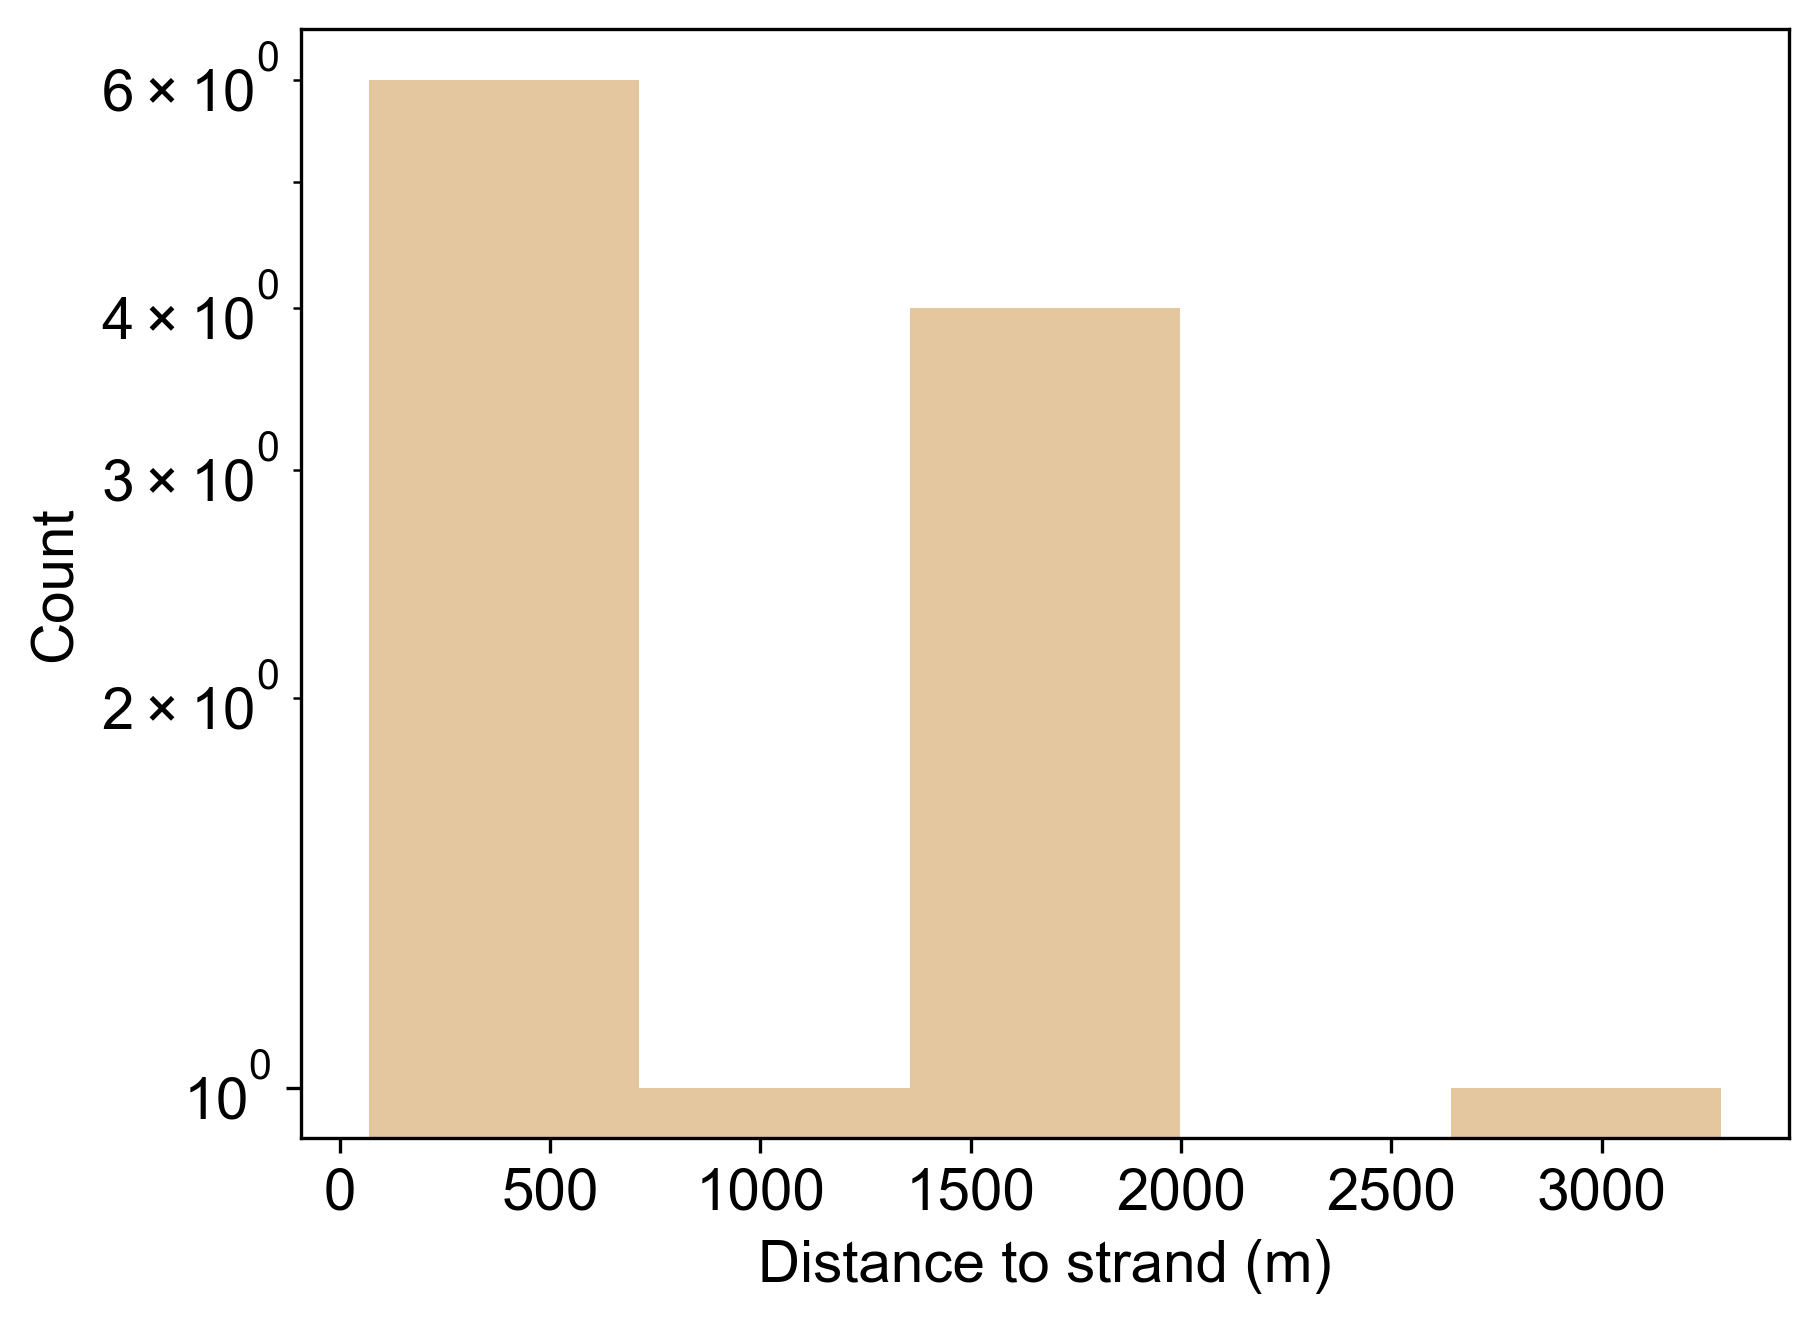

In [497]:
strand = grouped.get_group("strand")

bins = np.histogram_bin_edges(strand, bins=5, range=[1,max(strand['Length (m) or angle (deg)'])], weights=None)

sns.histplot(strand,x='Length (m) or angle (deg)',color='burlywood',edgecolor='none',alpha=0.8,label='Strand')
plt.yscale('log')
plt.xlabel('Distance to strand (m)')
plt.savefig('GRL/strand_RR.pdf')
plt.show() 

# Analysis of earthquake likelihood magnitude dependence

Extract passing probability for all mapped gates based on logistic models:
-- Note gaps, splays (statiscally indifferent), and strands are all assigned probabilities of 1 given the do not influence rupture propagation

In [498]:
fun_dict = {
    'log_stepover' : log_stepover,  
    'log_bend_single': log_bend_single,
    'log_bend_double':log_bend_double,
    'log_gap': log_gap
}

PR = []

for i in range(len(data)): 
    datai = data.iloc[i]
    featurei = datai['Feature']
    RRi = datai['Type (releasing or restraining)']

    if featurei == 'bend':
        RRi = datai['Type (releasing or restraining)']
        RRstr = str(RRi)

        if RRstr == 'nan':
            name_select = 'log' + '_' + 'bend' + '_' + 'single'
            extract = fun_dict[name_select]
            x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
            PRi  = extract.predict_proba(x)[:,0]

        else:
            name_select = 'log' + '_' + 'bend' + '_' + 'double'
            extract = fun_dict[name_select]
            x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
            PRi  = extract.predict_proba(x)[:,0]

    # elif featurei == 'gap':
    #     strlog = 'log'
    #     name_select = strlog + '_' + 'gap' 
    #     extract = fun_dict[name_select]
    #     x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
    #     PRi  = 1 #extract.predict_proba(np.log10(x))[:,0]

    elif featurei == 'stepover': 
        featurestr = str(featurei)
        strlog = 'log'
        RRstr = str(RRi)
        name_select = strlog + '_' + featurestr 
        extract = fun_dict[name_select]
        x = np.atleast_2d(datai['Length (m) or angle (deg)']).T
        PRi  = extract.predict_proba(np.log10(x))[:,0]
    
    else:
        PRi = 1
        

    PR.append(PRi)

data['PR'] = PR


Calculate earthquake likelihood for each event based on the previously estimated probabilities for each earthquake gate

In [499]:
event = data["Earthquake"]
event.unique()

mag = np.array([])
event_likelihood = np.array([])
event_group = event.unique()
cumdisp = np.array([])
SRL = np.array([])

for EQ in event_group:
    subset = data.loc[data['Earthquake'] == EQ]
    subsetb = subset.loc[subset['Breached or unbreached'] == "breached"]
    mag_i = subsetb['Magnitude']
    mag_i = mag_i.iloc[0]
    cum_disp_i = subsetb['Cumulative displacement']
    cum_disp_i = cum_disp_i.iloc[0]
    SRLi = subsetb['Total rupture length']
    SRLi = SRLi.iloc[0]

    subsetb['PR'] = subsetb['PR'].astype(float)
    subsetb['PRlog'] = np.log10(subsetb['PR'])   
    event_likelihood_i = np.sum(subsetb['PRlog'])

    print(mag_i,EQ,event_likelihood_i,SRLi)

    event_likelihood = np.append(event_likelihood, event_likelihood_i)
    mag = np.append(mag,mag_i)
    SRL = np.append(SRL,SRLi)
    cumdisp = np.append(cumdisp,cum_disp_i)

KeyError: 'Cumulative displacement'

In [ ]:
# probability of stopping on straight segment 
n_ends_no_gates = 10
total_SRL = np.sum(SRL)
p_straight = n_ends_no_gates/total_SRL
p_continue_straight = 1-p_straight

-1.7950551581116698 11.143529289759657 1.766937354799791
a = -1.795 +/- 0.258
b = 11.144 +/- 1.767
a = 7.629 +/- 1.307
b = -1.941 +/- 0.288


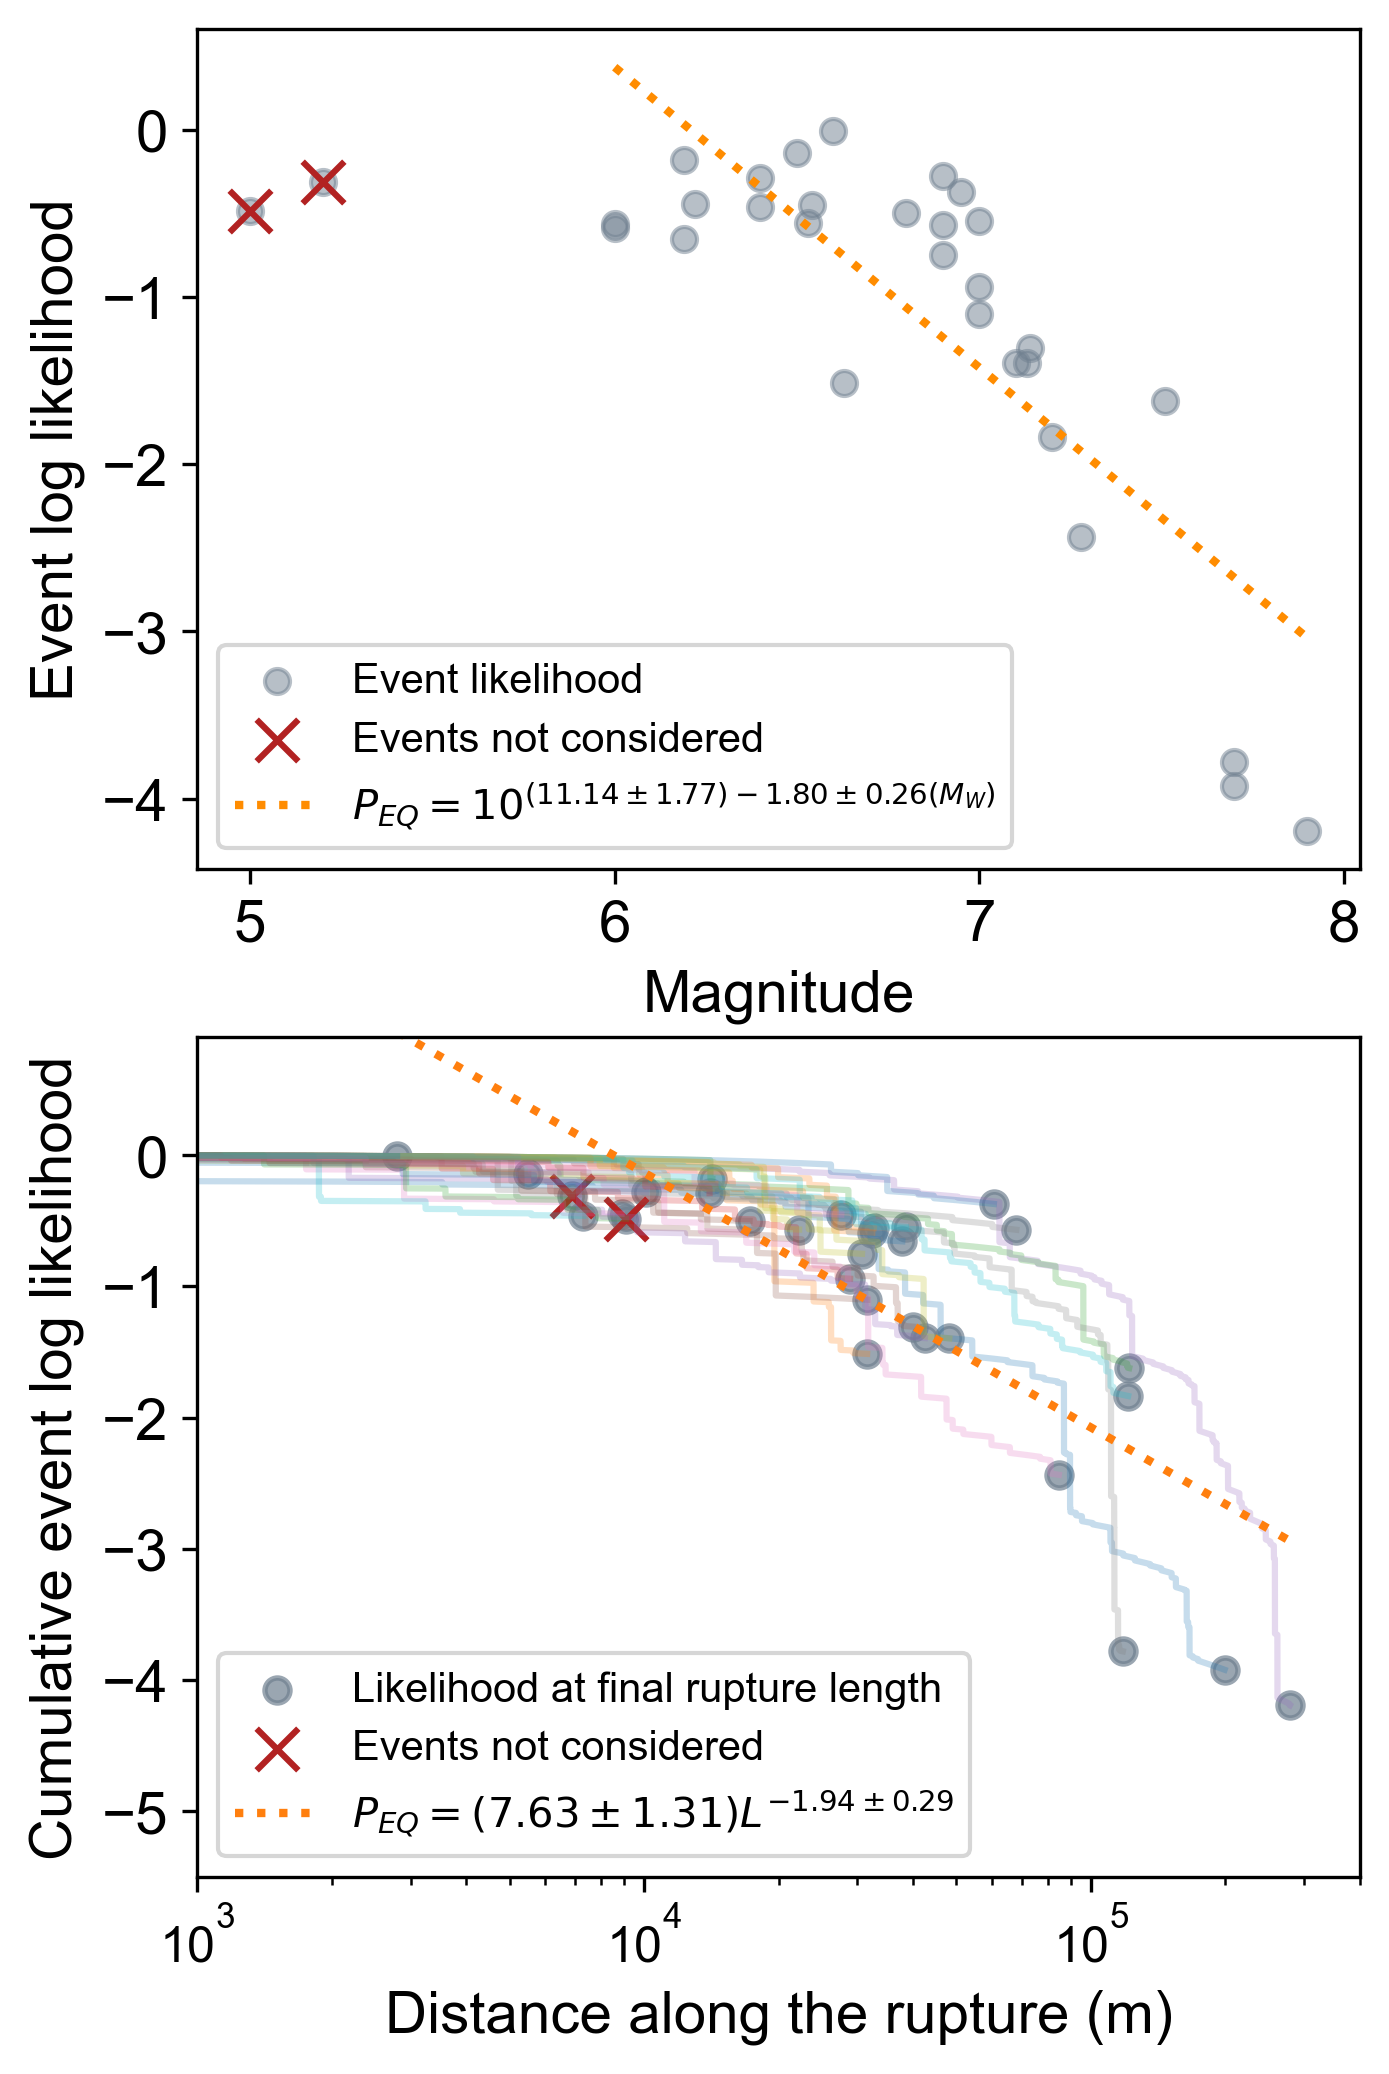

In [ ]:
fig, ax= plt.subplots(2,1,figsize=(5,8),dpi=300)
ax[0].scatter(mag,event_likelihood+np.log10(p_continue_straight)*SRL,c='slategrey',alpha=0.5,label='Event likelihood')#,edgecolors='slategrey')

# for i in range(len(event_group)):
#     plt.annotate(event_group[i], (mag[i], event_likelihood[i]+np.log10(p_continue_straight)*SRL[i]),fontsize=8)

# ax[0].scatter(mag,event_likelihood+np.log10(p_continue_straight)*SRL,c=cumdisp,cmap='cividis',label='Number of segments',norm=mcolors.LogNorm())
# plt.colorbar(ax=ax[0])

idx = np.where(mag < 6) # remove outliers, i.e., events too small for proper rupture propagation to the surface
ax[0].scatter(mag[idx],event_likelihood[idx]+np.log10(p_continue_straight)*SRL[idx],c='firebrick',marker='x',s=100,label='Events not considered')

# for i in range(len(event_group)):
#     if np.isin(i, idx):
#         ax[0].annotate(event_group[i], (mag[i], event_likelihood[i]+np.log10(p_continue_straight)*SRL[i]),fontsize=8)

mag_del = np.delete(mag, idx)
cumdisp = np.delete(cumdisp,idx)
event_likelihood_del = np.delete(event_likelihood, idx)
SRL_del = np.delete(SRL, idx)

##### fit data with linear regression in semilog space (pwl bc mag is logged already)
all_info = stats.linregress(mag_del, event_likelihood_del+np.log10(p_continue_straight)*SRL_del)
# slope, intercept, r_value, p_value, std_err, intercept_stderr
print(all_info.slope,all_info.intercept, all_info.intercept_stderr)

# Define the x range for the line plot
x_range = np.linspace(min(mag_del), max(mag_del), 100)

# Calculate the y values for the line plot
y_range = all_info.slope * x_range + all_info.intercept

# Plot the data and the line fit with error bars
ax[0].plot(x_range, y_range, label=r"$P_{EQ} = 10^{(%.2f \pm %.2f) %.2f \pm  %.2f(M_W) }$" % (all_info.intercept,all_info.intercept_stderr,all_info.slope,all_info.stderr),linestyle=':',c='darkorange',linewidth=2)
#ax[0].fill_between(x_range, y_range - std_err, y_range + std_err, alpha=0.2,color='darkorange',label='Standard error')

#ax[0].set_ylim([-5.5, 0.9])
ax[0].set_ylabel('Event log likelihood')
ax[0].set_xlabel('Magnitude')
ax[0].legend(fontsize=10)

# # Print the fitted parameters and errors
print("a = {:.3f} +/- {:.3f}".format(all_info.slope,all_info.stderr))
print("b = {:.3f} +/- {:.3f}".format(all_info.intercept, all_info.intercept_stderr))

######################################################## cumulative probability

lastpt = []
keeplikelihood = event_likelihood+np.log10(p_continue_straight)*SRL

for EQ in event_group:
    subset = data.loc[data['Earthquake'] == EQ]
    subsetb = subset.loc[subset['Breached or unbreached'] == "breached"]
    subsetb = subsetb.reset_index(drop=True)
    subsetb['PR'] = subsetb['PR'].astype(float)

    gatelikelihood = subsetb['PR']
    gateloglikelihood = np.log10(subsetb['PR'])
    
    gateloc = subsetb['Location along rupture']
    subsetb['Approx_Location'] = subsetb['Location along rupture'].round().astype(int)

    SRL_event = subsetb['Total rupture length']   
    surf_length = SRL_event[0]
    surf_length = round(surf_length)
    probframe = pd.DataFrame()
    SRL_points = list(range(surf_length))
    new_rows = pd.DataFrame({'surf_length': SRL_points})
    probframe = probframe.append(new_rows, ignore_index=True)
    probframe['prob_straight_segment'] = p_continue_straight
    merged_df = pd.merge(probframe, subsetb, left_on='surf_length', right_on='Approx_Location', how='left')
    merged_df['prob'] = merged_df.apply(lambda row: row['PR'] if not pd.isnull(row['PR']) else row['prob_straight_segment'], axis=1)
    merged_df['cumulative_sum'] = np.log10(merged_df['prob']).cumsum()

    lastpt.append(max(SRL_points))

    # now we plot the data and fit the model:    
    sns.lineplot(data=merged_df,x=merged_df['surf_length'],y=merged_df['cumulative_sum'],palette="blend:#7AB,#EDA",alpha=0.25,ax=ax[1]) 

ax[1].scatter(lastpt,keeplikelihood,c='slategrey',alpha=0.7,label='Likelihood at final rupture length',linewidth=1.3)
lastpt = np.array(lastpt)
keeplikelihood = np.array(keeplikelihood)
ax[1].scatter(lastpt[idx],keeplikelihood[idx],c='firebrick',marker='x',s=100,label='Events not considered')

# for i in range(len(event_group)):
#     if np.isin(i, idx):
#         ax[1].annotate(event_group[i], (lastpt[i], keeplikelihood[i]),fontsize=8)

#ax[1].set_xscale('log')
ax[1].set_ylabel('Cumulative event log likelihood')
ax[1].set_xlabel('Distance along the rupture (m)')
ax[1].set_ylim([-5.5, 0.9])
ax[1].set_xlim([10**3, 400*10**3])

lastpt = np.delete(lastpt,idx)
keeplikelihood = np.delete(keeplikelihood,idx)

# # Fit the data to the power-law function
popt, pcov = curve_fit(power_law, lastpt, keeplikelihood)

# # Calculate the errors
perr = np.sqrt(np.diag(pcov))

# # Print the fitted parameters and errors
print("a = {:.3f} +/- {:.3f}".format(popt[0], perr[0]))
print("b = {:.3f} +/- {:.3f}".format(popt[1], perr[1]))

# # Plot the power-law fit
xfit = np.linspace(min(lastpt),max(lastpt), 1000)
yfit = power_law(xfit, *popt)
ax[1].plot(xfit, yfit, label=r"$P_{EQ} = (%.2f \pm %.2f) L^{%.2f \pm  %.2f}$" % (popt[0],perr[0], popt[1],perr[1]),linestyle=':',linewidth=2)

# # Show the plot
plt.xscale('log')
ax[1].legend(fontsize=10)
ax[1].tick_params(axis='x', labelsize=12)
plt.savefig('GRL/mag_dependence_CDF_likelihood.pdf')
plt.show()

[2.23185355 1.00448148]


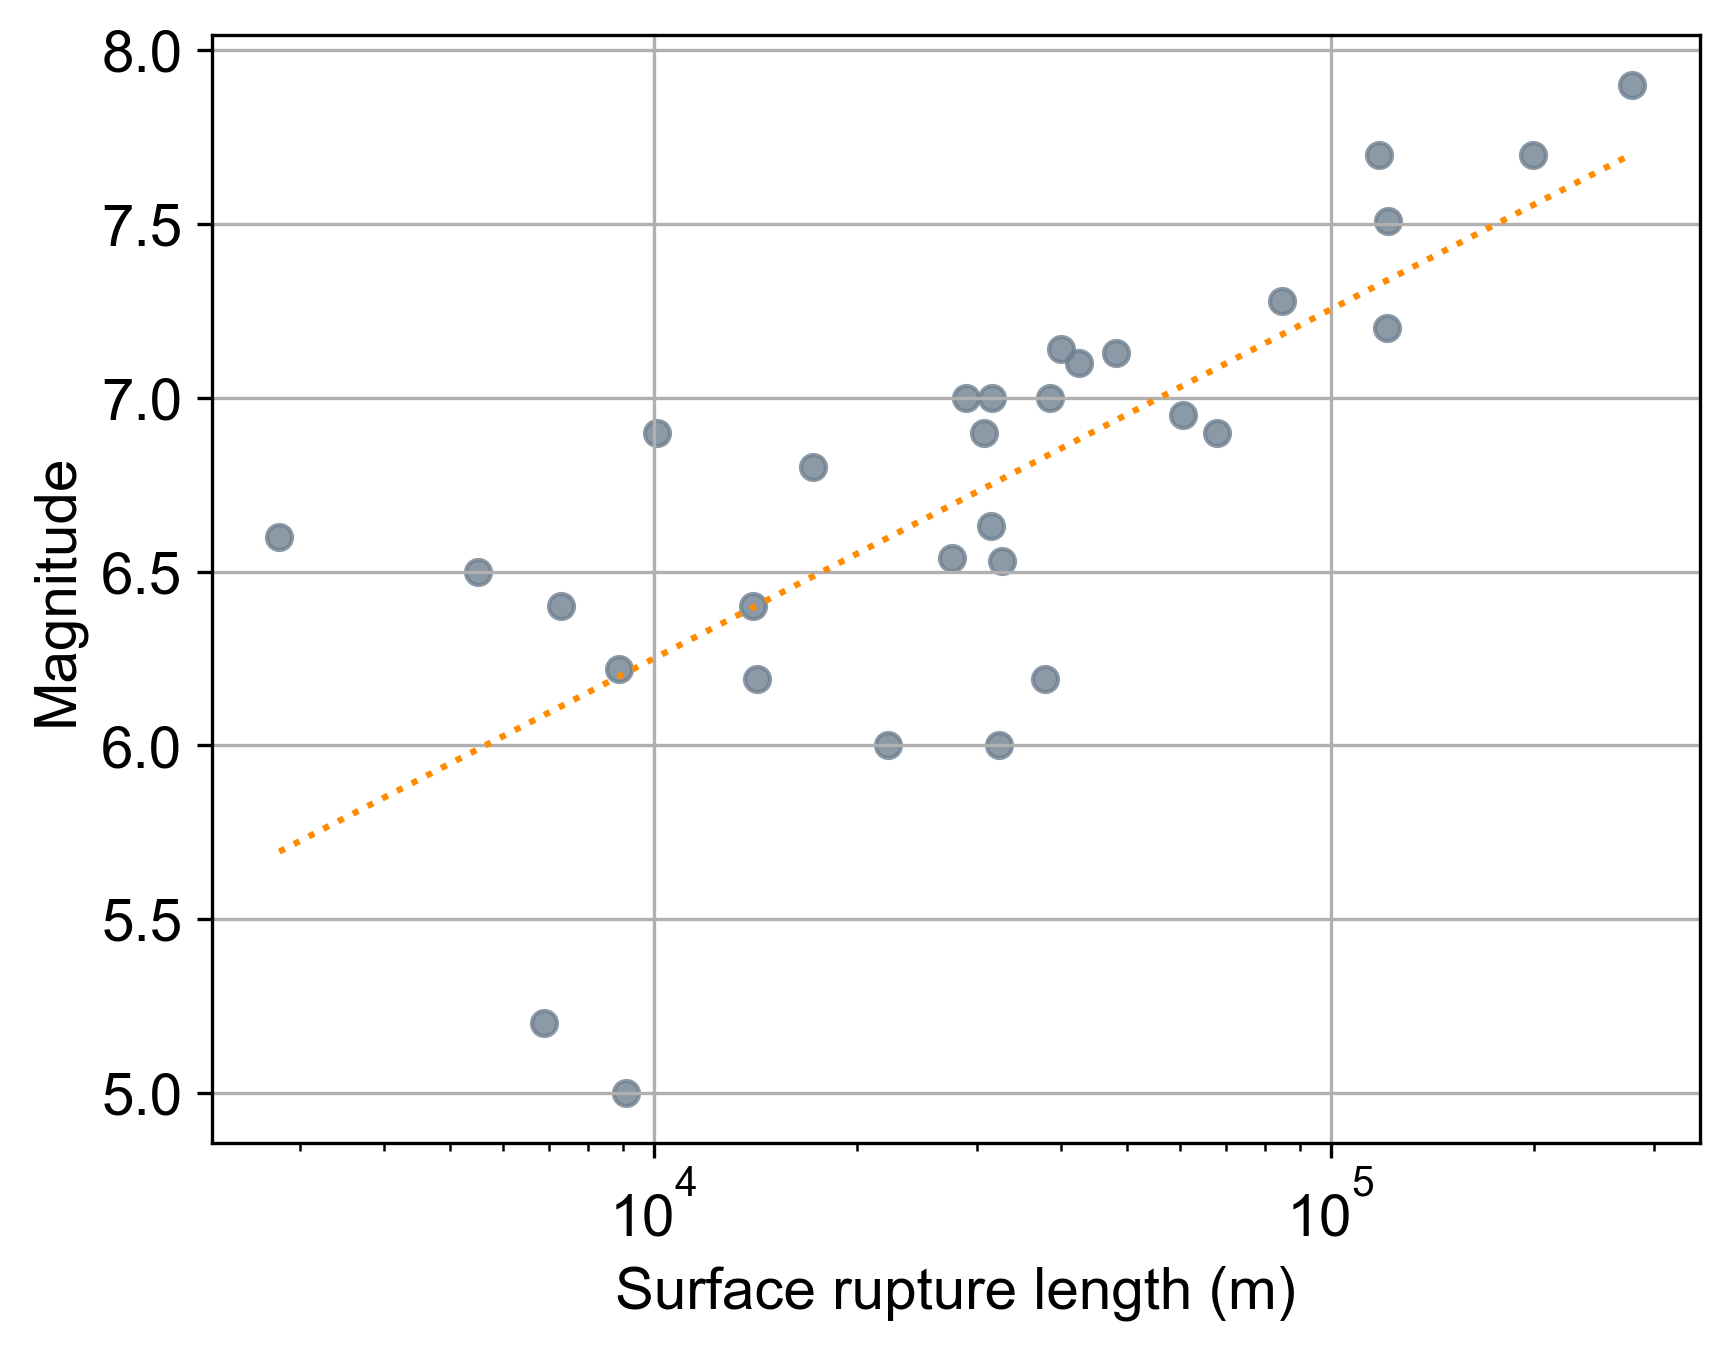

In [ ]:
# for each event find magnitude and surface rupture length
plt.figure()
plt.scatter(SRL,mag,color='slategrey',alpha=0.8)
plt.xlabel('Surface rupture length (m)')
plt.ylabel('Magnitude')
plt.xscale('log')
plt.grid()

# # Define the power-law function
def power_law(x, a, b):
     return b*np.log10(x)+a

# # Fit the data to the power-law function
popt, pcov = curve_fit(power_law, SRL, mag)


# # Plot the power-law fit
xfit = np.linspace(min(SRL),max(SRL), 1000)
yfit = power_law(xfit, *popt)
plt.plot(xfit, yfit,linestyle=':',color='darkorange')

print(popt)


# Earthquake gates along rupture analysis

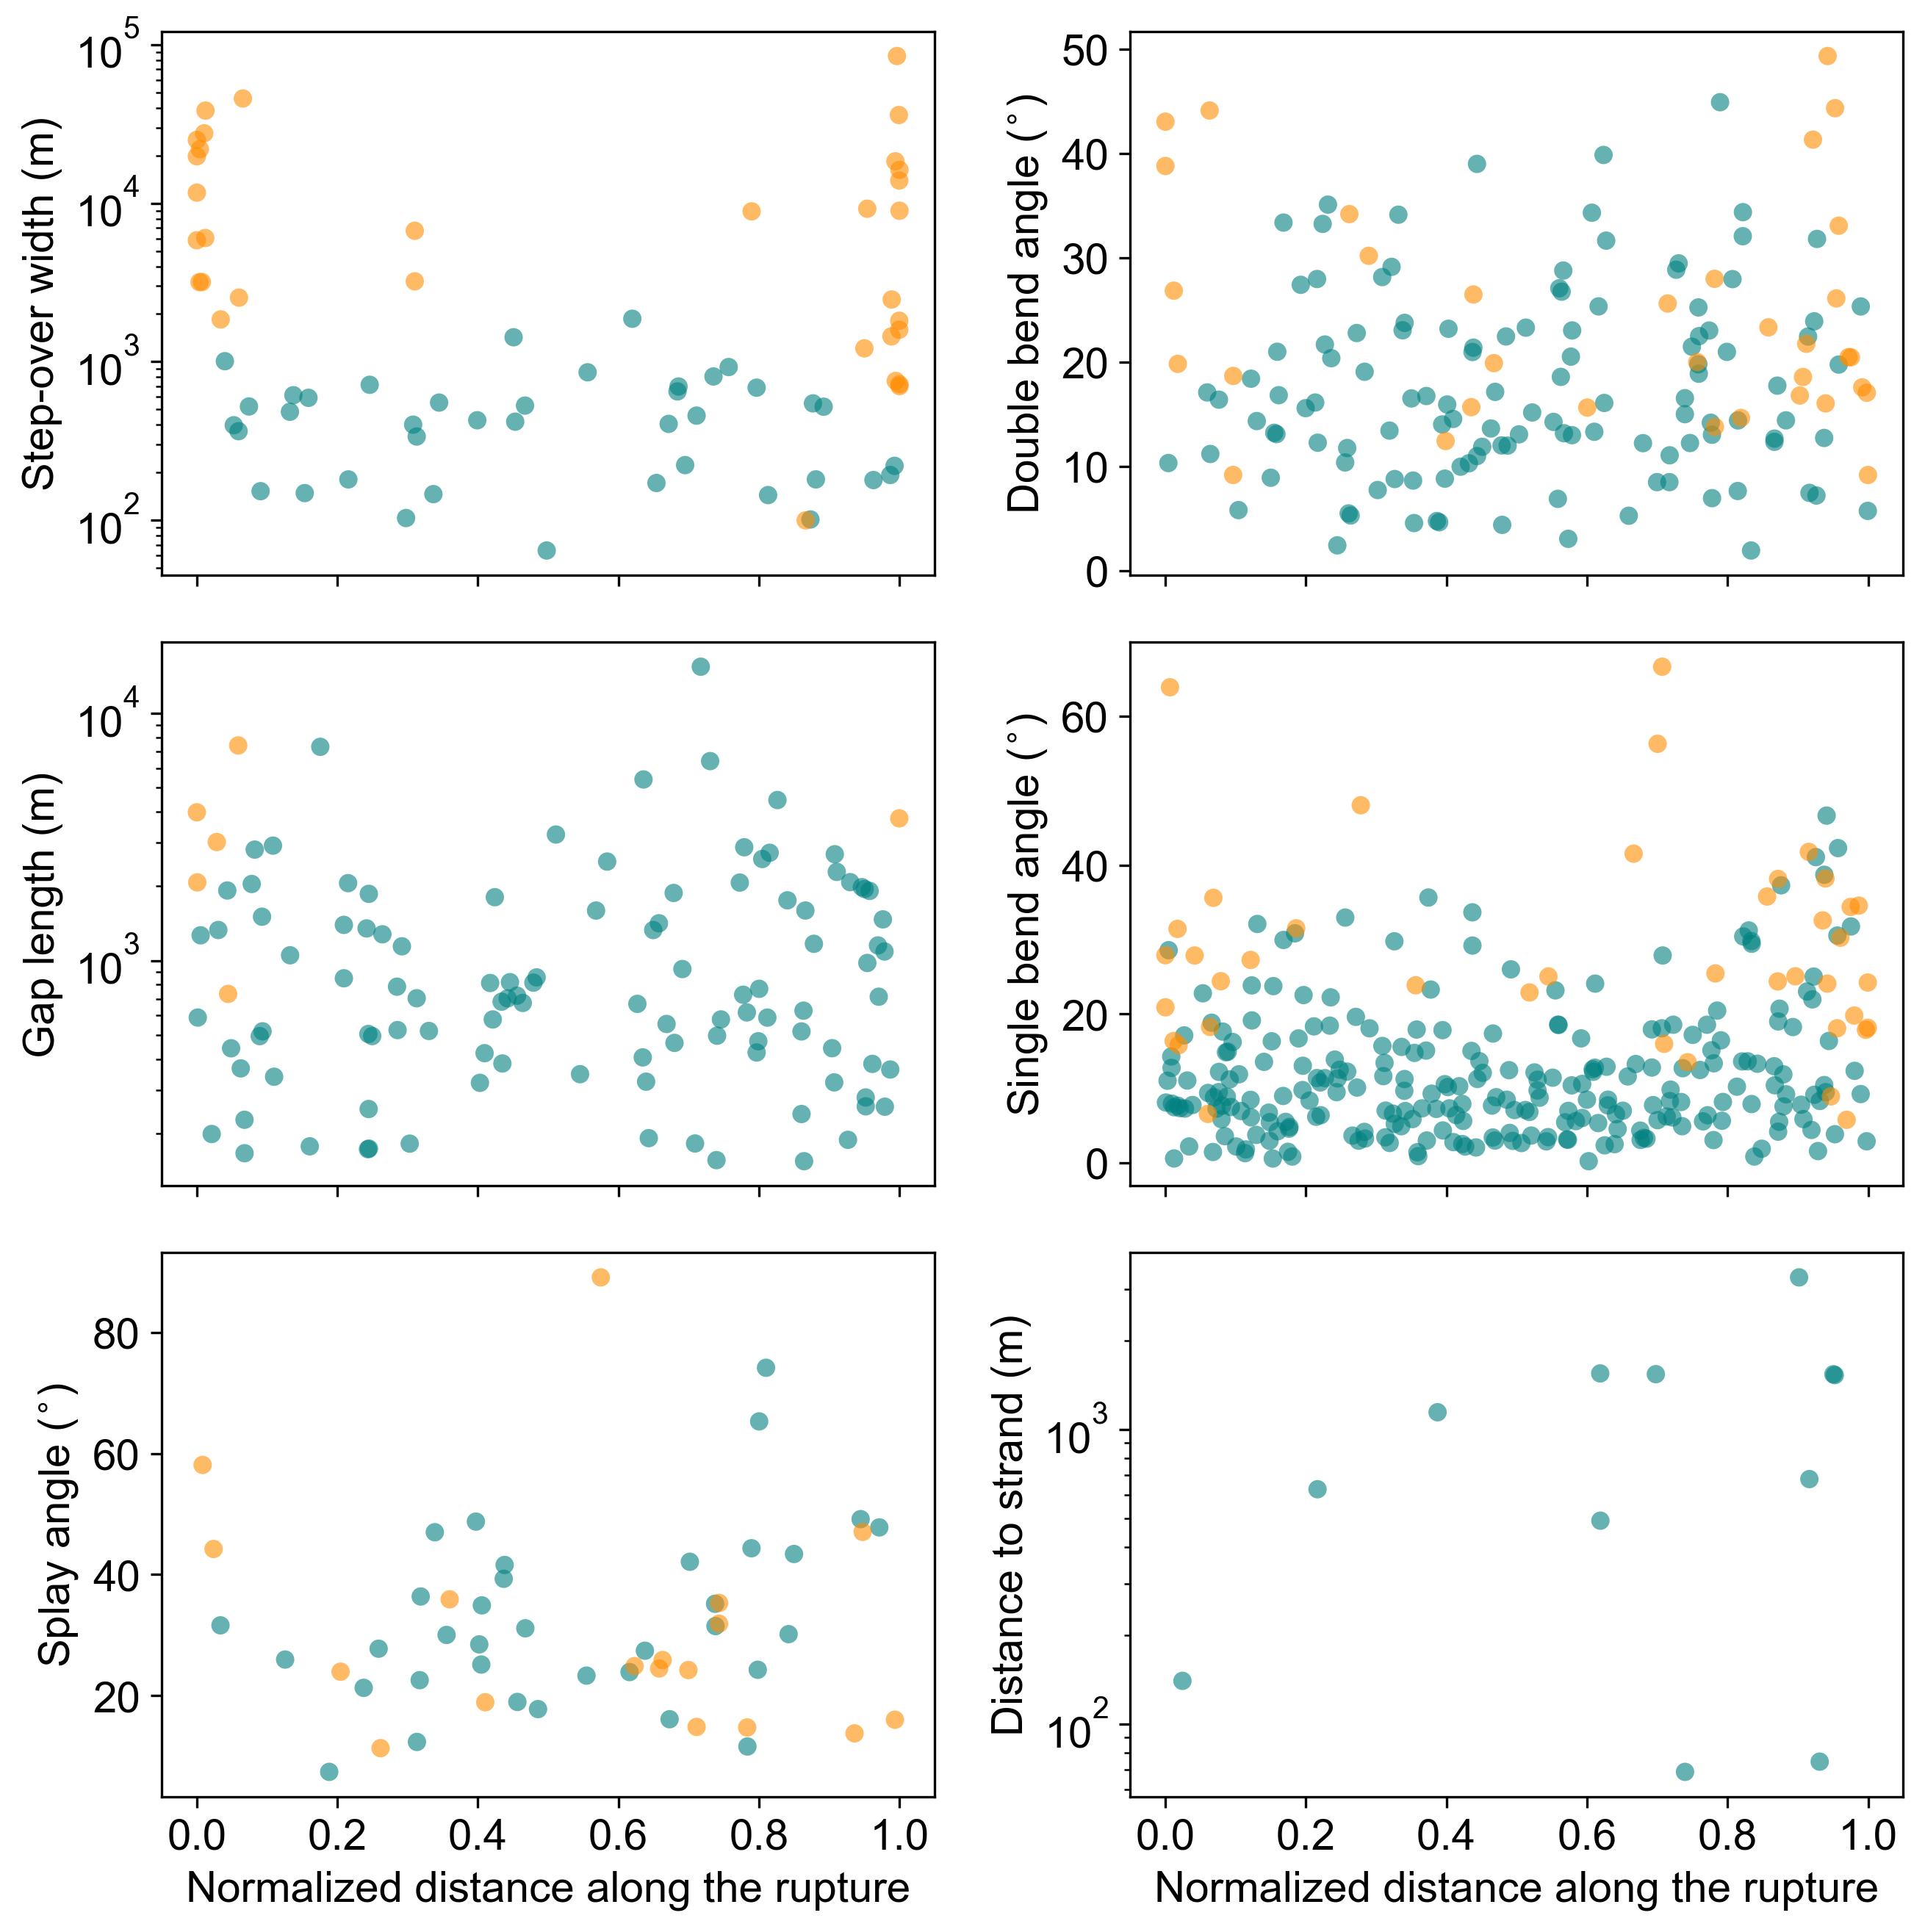

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(9, 9),sharex=True,dpi=300)
palette = {'breached': 'teal', 'unbreached': 'darkorange'}
gate_distribution_along_strike(grouped,'stepover','none','length',axes[0,0],'Step-over width (m)',palette)
gate_distribution_along_strike(grouped,'bend','double','angle',axes[0,1],'Double bend angle ($^{\circ}$)',palette)
gate_distribution_along_strike(grouped,'bend','single','angle',axes[1,1],'Single bend angle ($^{\circ}$)',palette)
gate_distribution_along_strike(grouped,'gap','none','length',axes[1,0],'Gap length (m)',palette)
gate_distribution_along_strike(grouped,'splay','none','angle',axes[2,0],'Splay angle ($^{\circ}$)',palette)
gate_distribution_along_strike(grouped,'strand','none','length',axes[2,1],'Distance to strand (m)',palette)
plt.tight_layout()
plt.savefig('GRL/Normalized_dist_size.pdf')
plt.show()


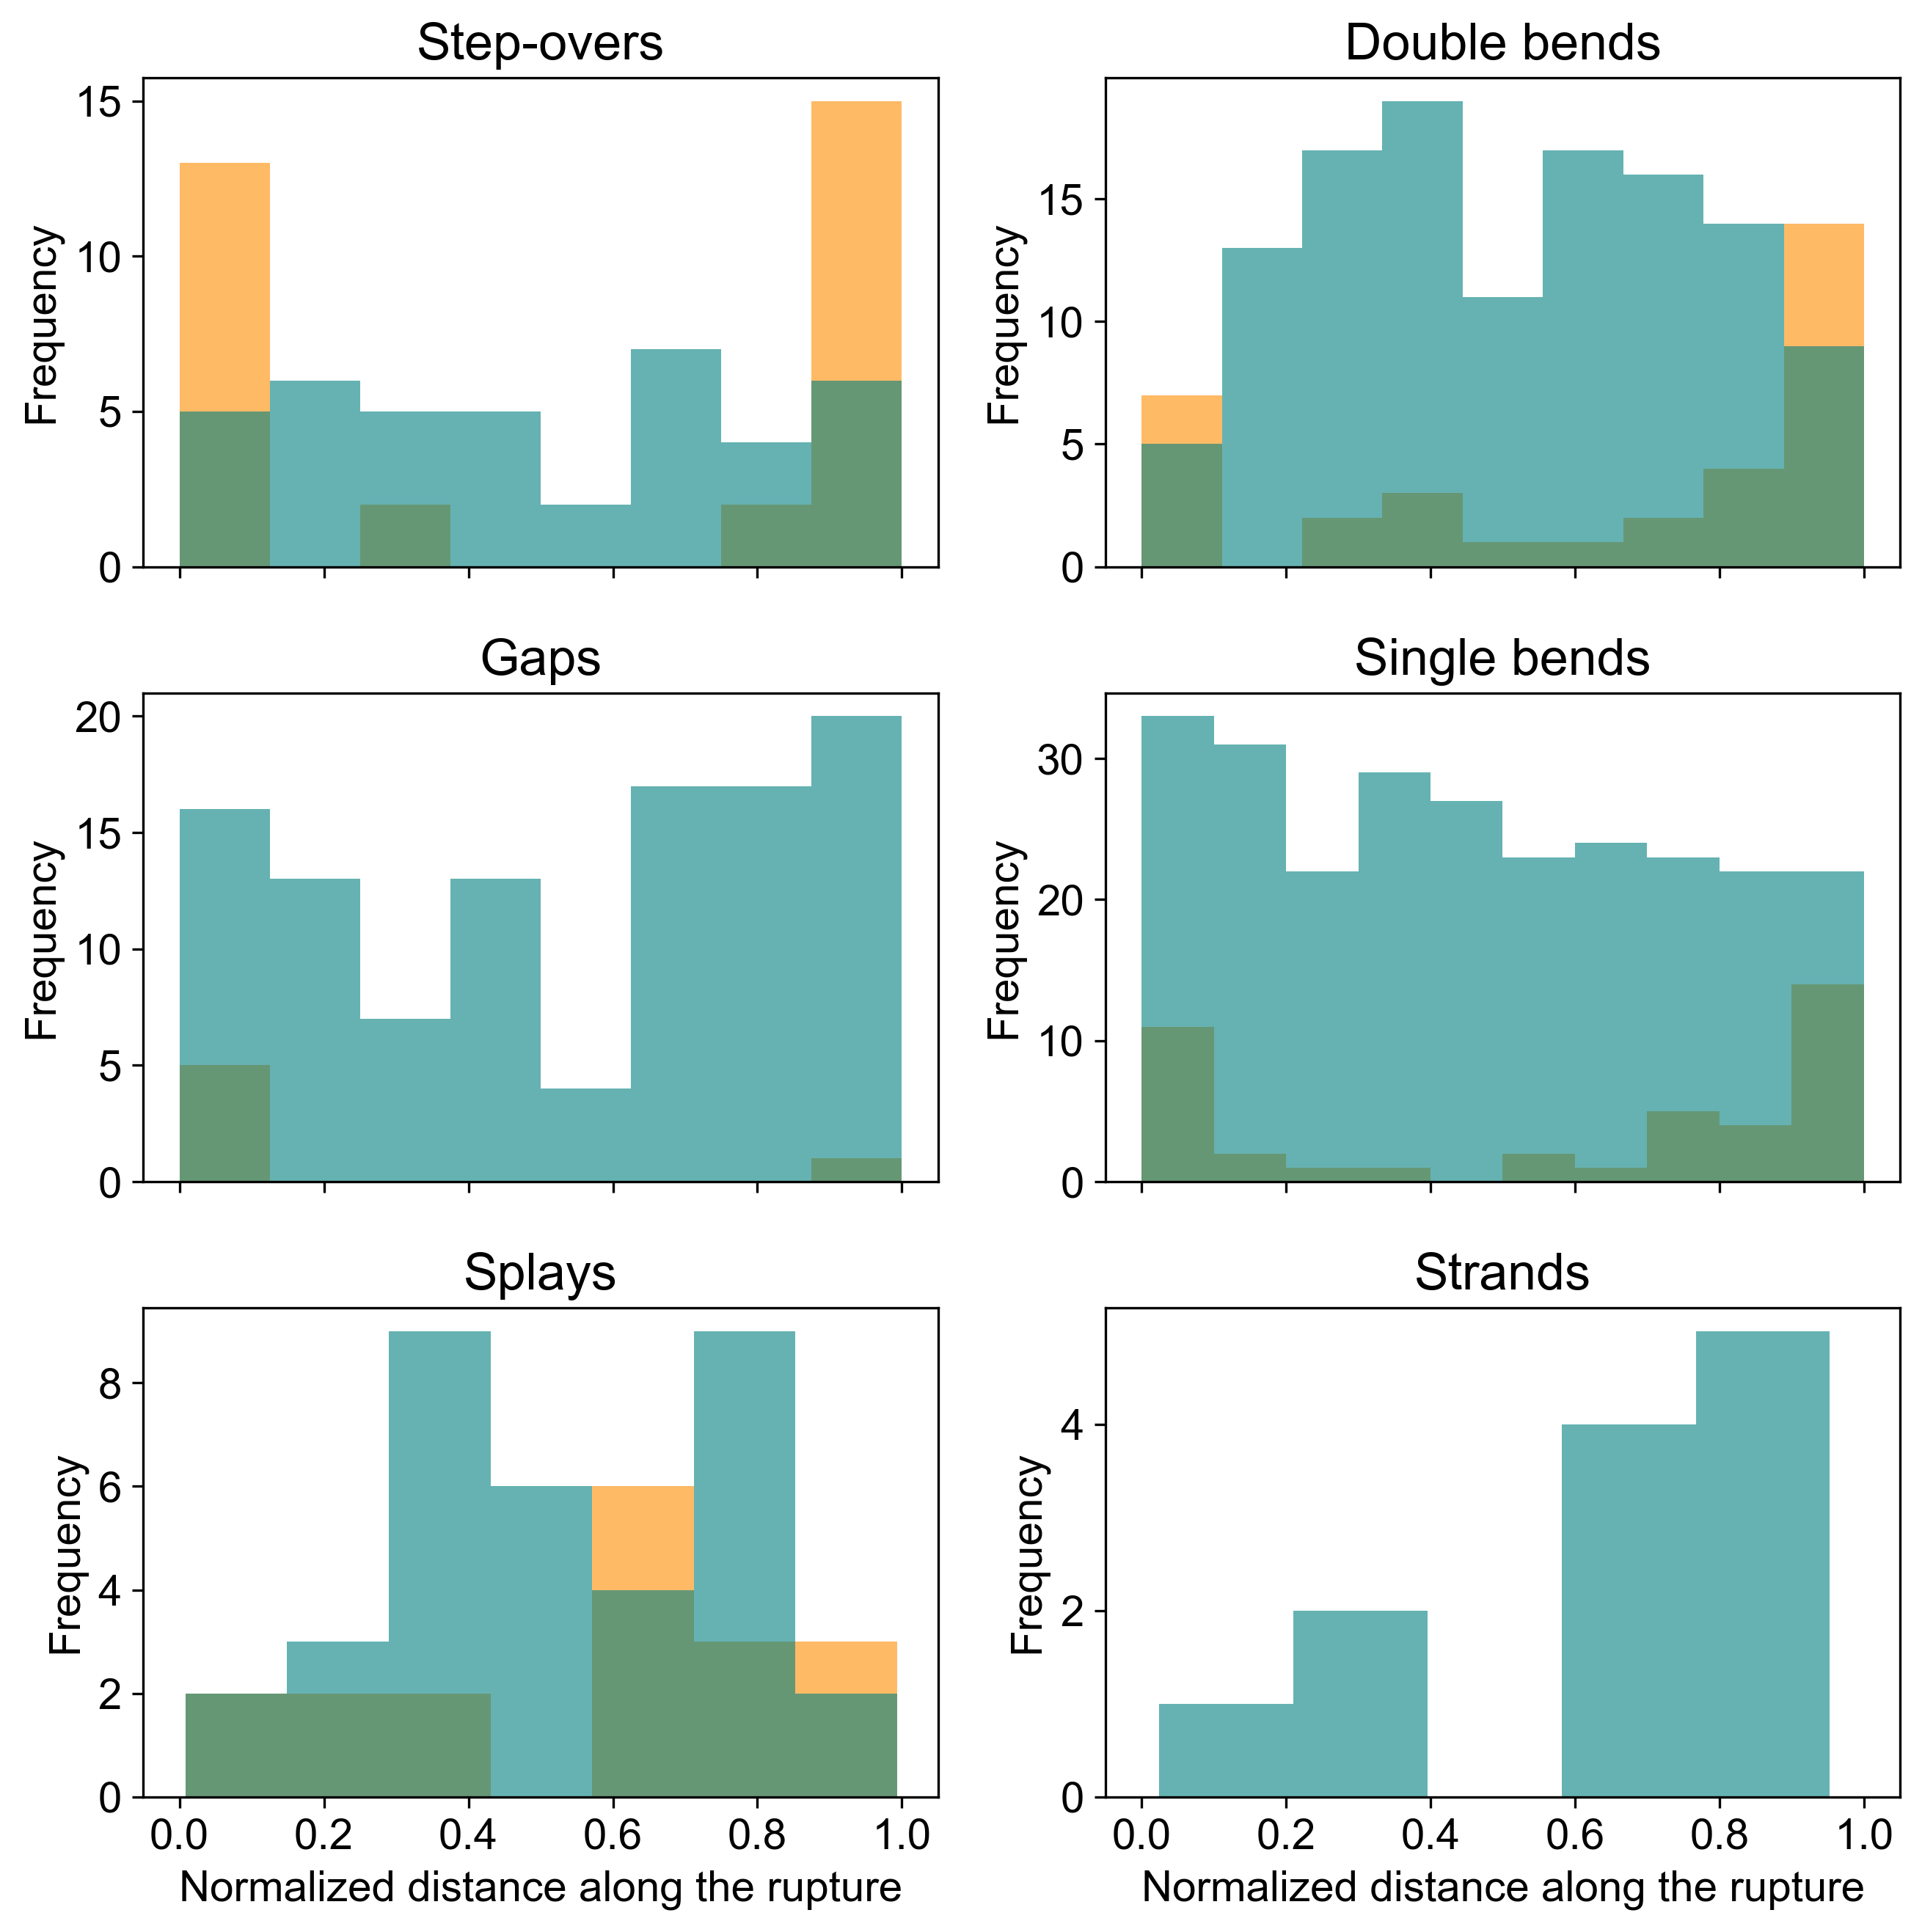

In [ ]:
fig, axes = plt.subplots(3,2,figsize=(9, 9),sharex=True,dpi=300)
palette = {'breached': 'teal', 'unbreached': 'darkorange'}
gate_distribution_along_strike_histogram(grouped,'stepover','none','length',axes[0,0],'Step-overs',palette)
gate_distribution_along_strike_histogram(grouped,'bend','double','angle',axes[0,1],'Double bends',palette)
gate_distribution_along_strike_histogram(grouped,'bend','single','angle',axes[1,1],'Single bends',palette)
gate_distribution_along_strike_histogram(grouped,'gap','none','length',axes[1,0],'Gaps',palette)
gate_distribution_along_strike_histogram(grouped,'splay','none','angle',axes[2,0],'Splays',palette)
gate_distribution_along_strike_histogram(grouped,'strand','none','length',axes[2,1],'Strands',palette)
plt.tight_layout()
plt.savefig('GRL/Normalized_dist_size_histogram.pdf')
plt.show()

## Comparison to previous studies

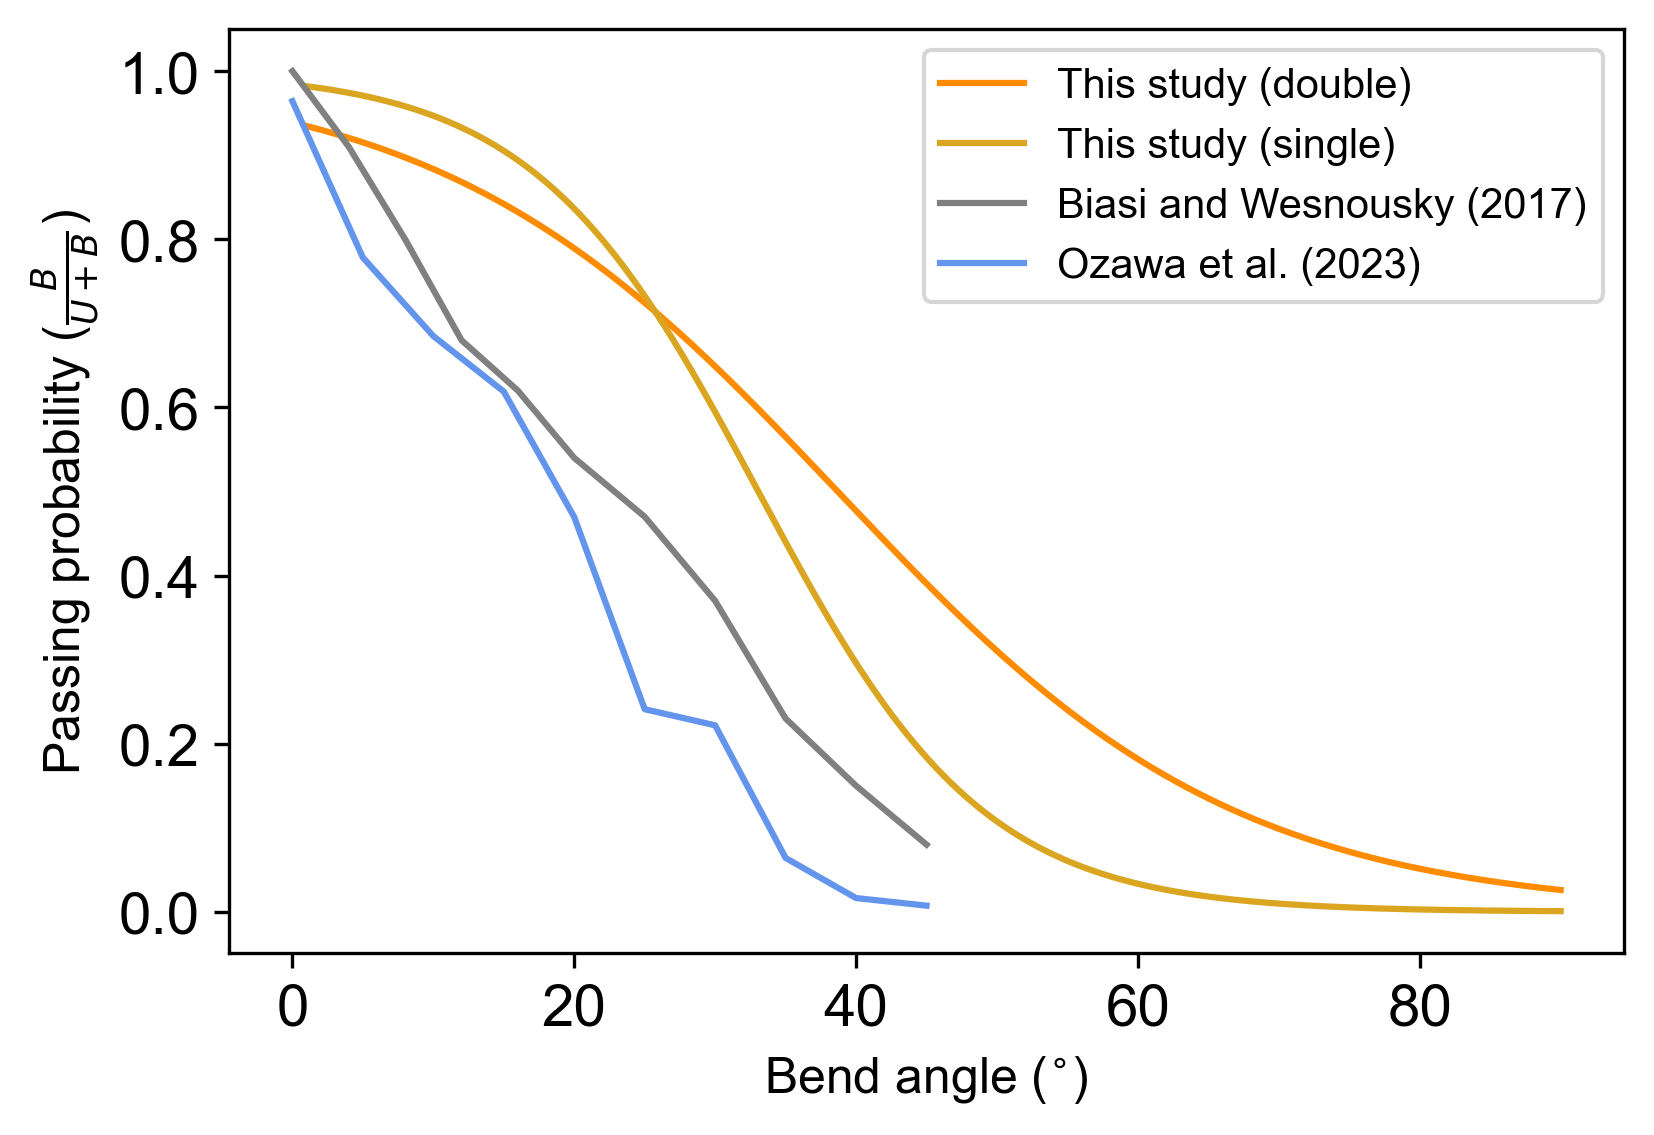

In [ ]:
group = grouped.get_group('bend')
selectB= group.groupby(group["Type (single or double)"])
double = selectB.get_group('double')
double['Bin'] = pd.cut(double['Length (m) or angle (deg)'], bins=np.linspace(0,90,10)) 
double['Bin Middle'] = double['Bin'].apply(lambda x: (x.left + x.right) / 2)

breached_counts = double[double['Breached or unbreached'] == 'breached'].groupby('Bin Middle').size()

unbreached_counts = double[double['Breached or unbreached'] == 'unbreached'].groupby('Bin Middle').size()

ratio = (breached_counts/(unbreached_counts+breached_counts))

unique_values = np.linspace(0,90,10)
unique_values = calculate_center(unique_values)

plt.figure(figsize=(6,4),dpi=300)
#plt.plot(unique_values,ratio,c='darkorange',label='This study (double)')
x = np.atleast_2d(np.linspace(1, 90, 1000)).T
proba_double = log_bend_double.predict_proba(x)[:,0]
proba_single = log_bend_single.predict_proba(x)[:,0]

plt.plot(x,proba_double,c='darkorange',label='This study (double)')
plt.plot(x,proba_single,c='goldenrod',label='This study (single)')
group = grouped.get_group('bend')
selectB= group.groupby(group["Type (single or double)"])
single = selectB.get_group('single')
single['Bin'] = pd.cut(single['Length (m) or angle (deg)'], bins=np.linspace(0,90,10)) 
single['Bin Middle'] = single['Bin'].apply(lambda x: (x.left + x.right) / 2)

breached_counts = single[single['Breached or unbreached'] == 'breached'].groupby('Bin Middle').size()

unbreached_counts = single[single['Breached or unbreached'] == 'unbreached'].groupby('Bin Middle').size()

ratio = (breached_counts/(unbreached_counts+breached_counts))

unique_values = np.linspace(0,90,10)
unique_values = calculate_center(unique_values)
#plt.plot(unique_values,ratio,c='goldenrod',label='This study (single)')

# load data from Biasi and Wesnousky (2017) and Ozawa et al. (2023)
Bend_angle_Biasi = np.array([0, 4, 8, 12, 16, 20, 25, 30, 35, 40, 45])
PP_Biasi = np.array([1, 0.91, 0.80, 0.68, 0.62, 0.54, 0.47, 0.37, 0.23, 0.15, 0.08])

Bend_angle_Ozawa = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45])
PP_Ozawa = np.array([0.96428571, 0.77829376, 0.68489335, 0.61890165, 0.46959471, 0.24105128, 0.22185883, 0.06410775, 0.01640081, 0.00738151])

plt.plot(Bend_angle_Biasi, PP_Biasi,'gray',label='Biasi and Wesnousky (2017)')
plt.plot(Bend_angle_Ozawa,PP_Ozawa,'cornflowerblue', label='Ozawa et al. (2023)')
plt.ylabel(r'Passing probability ($\frac{B}{U+B}$)',fontsize=12)
plt.xlabel(r'Bend angle ($^{\circ}$)',fontsize=12)
plt.legend(fontsize=10)
plt.savefig('GRL/bendPPcomparisons.pdf')

# Displacement at EQ gate

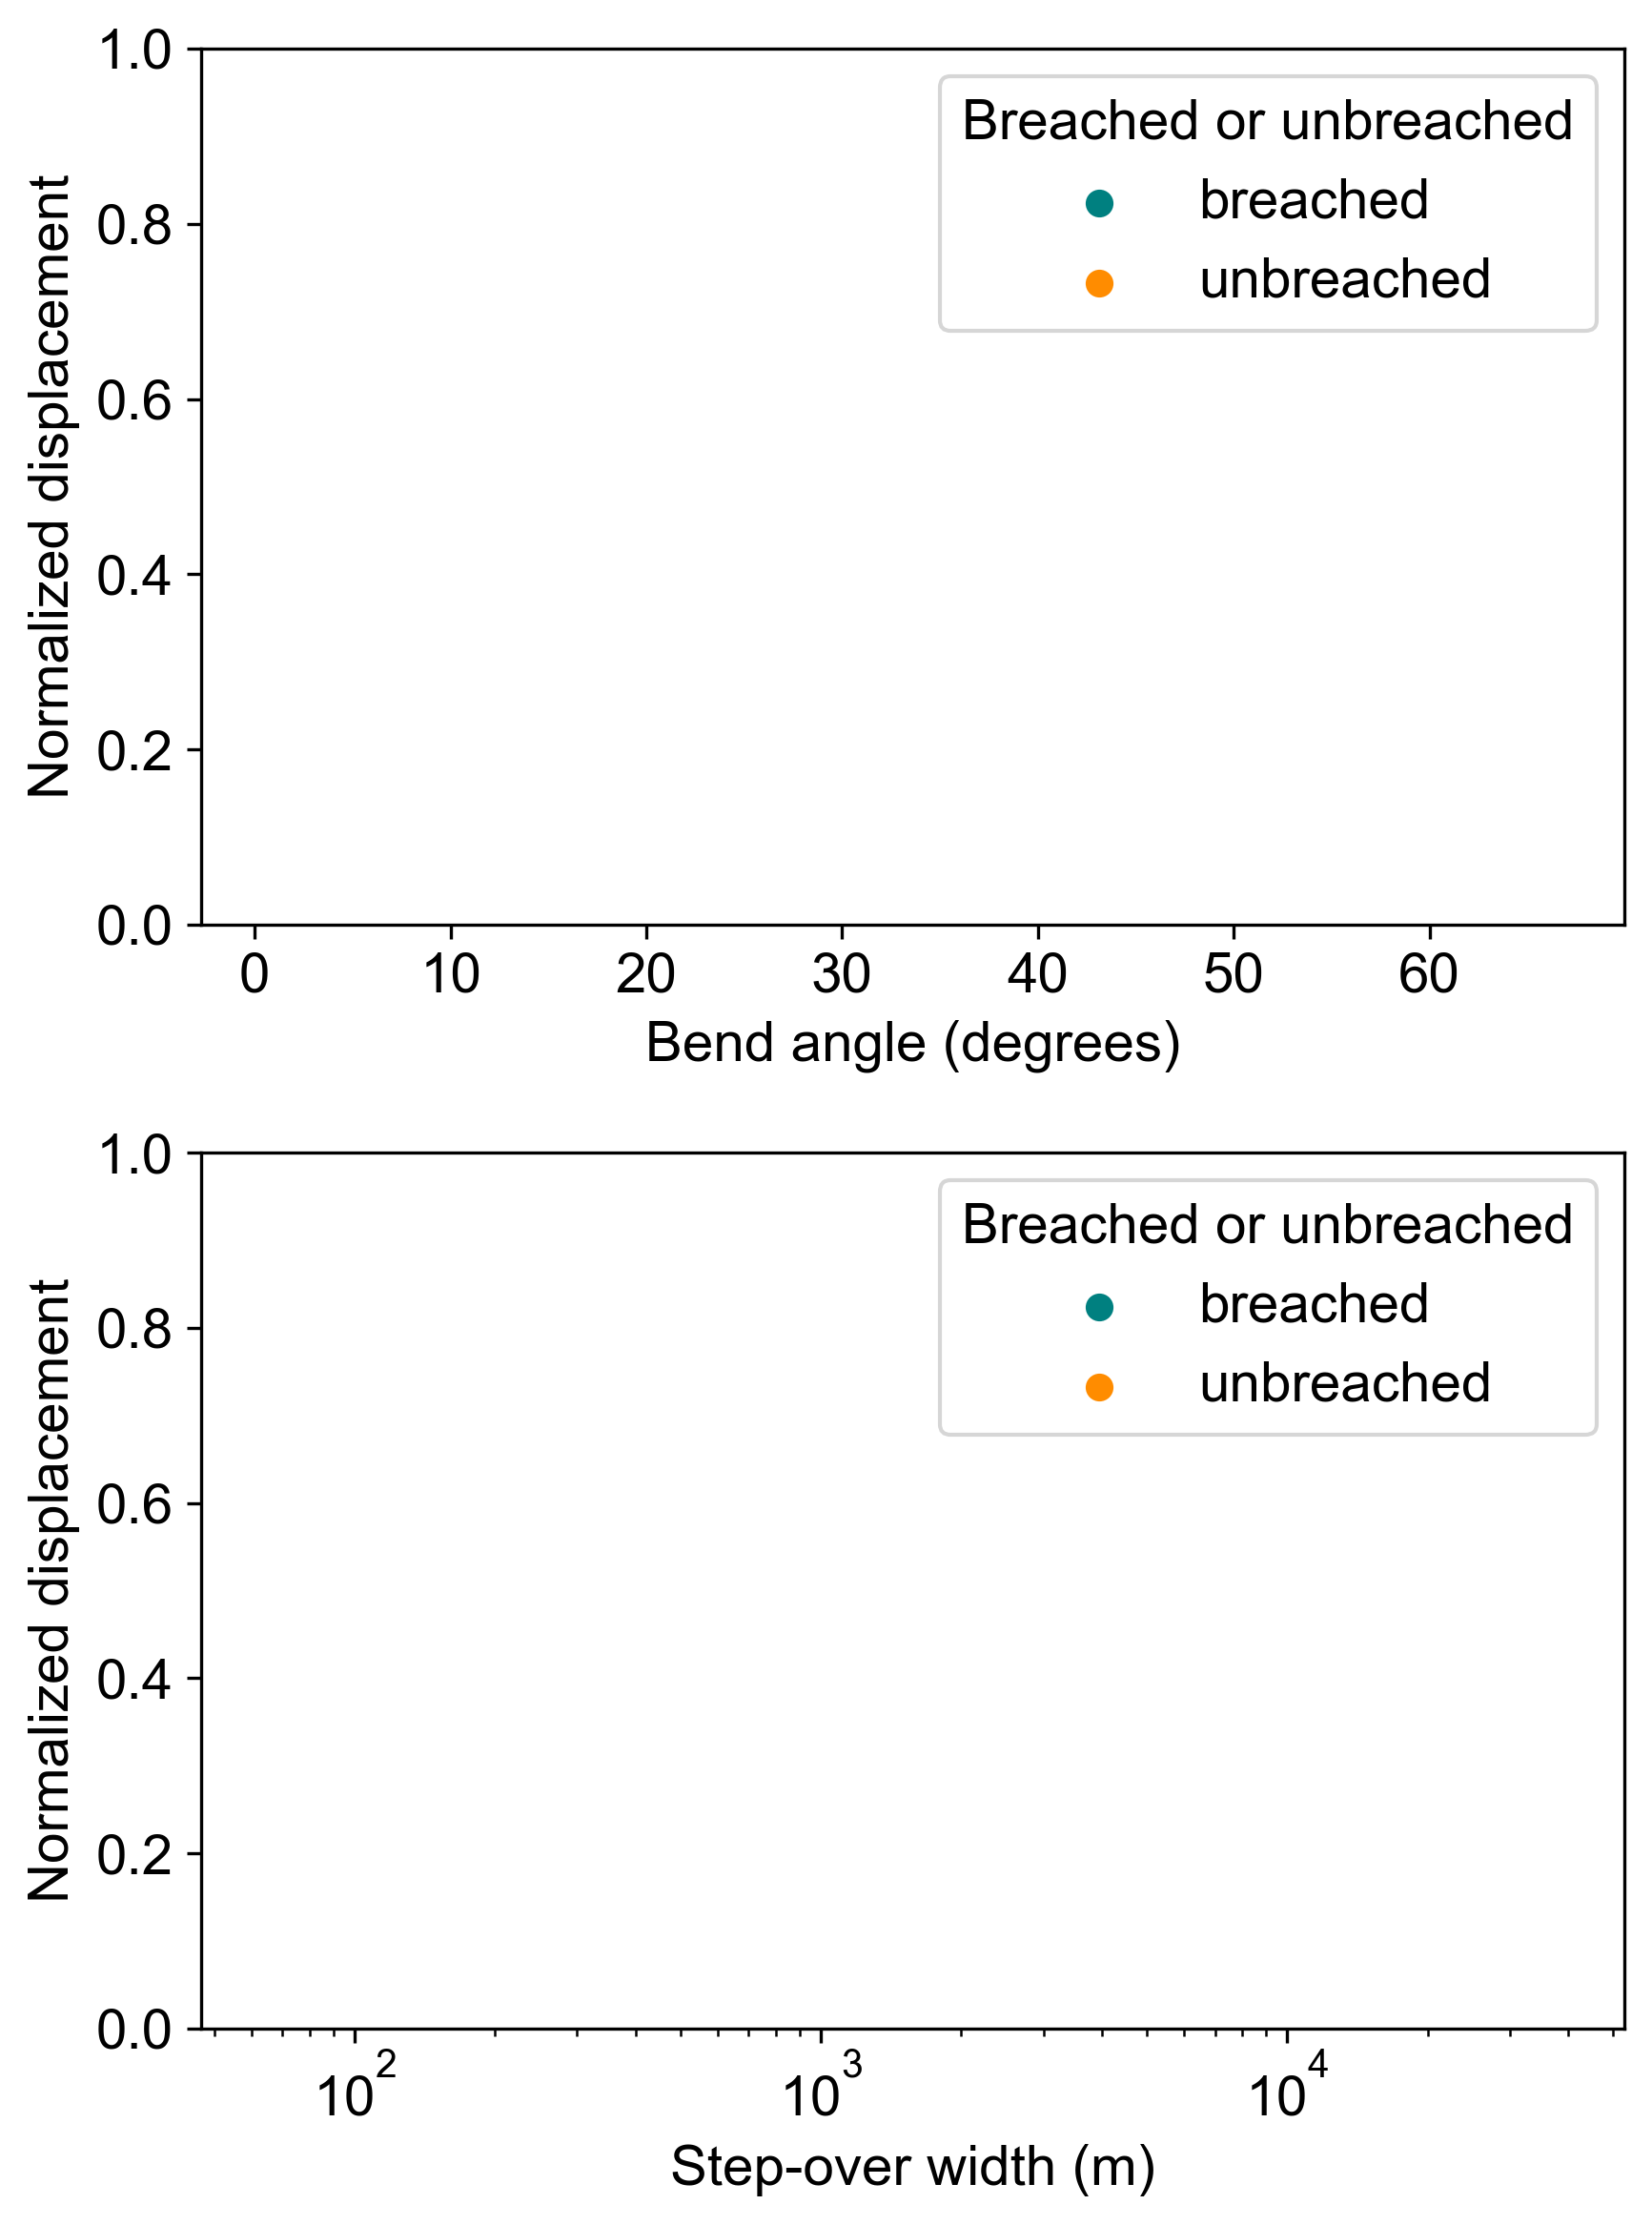

In [ ]:
bends = grouped.get_group('bend')
stepovers = grouped.get_group('stepover')

custom_palette = {"breached": "teal", "unbreached": "darkorange"}

fig, axes = plt.subplots(2,1,figsize=(6,8),dpi=300)
sns.scatterplot(data=bends, x='Length (m) or angle (deg)', y='Normalized slip at gate', hue='Breached or unbreached', alpha=0.8, palette=custom_palette,ax=axes[0])
axes[0].set_xlabel('Bend angle (degrees)')
axes[0].set_ylabel('Normalized displacement')
axes[0].set_ylim(0,1)

sns.scatterplot(data=stepovers, x='Length (m) or angle (deg)', y='Normalized slip at gate', hue='Breached or unbreached', alpha=0.8, palette=custom_palette,ax=axes[1])
axes[1].set_xlabel('Step-over width (m)')
axes[1].set_xscale('log')
axes[1].set_ylabel('Normalized displacement')
axes[1].set_ylim(0,1)

plt.tight_layout()
plt.savefig('GRL/normalized_slip_at_gate.pdf')